# Identifying potential priority local authorities in England for intergenerational care facilities

## 1. Data

### 1.1. Import libraries

In [1]:
# Data importing / wrangling
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from scipy import stats
import numpy as np

# Visualisations
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import seaborn as sns
import folium
import contextily as cx

# Clustering
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
import statsmodels.api as sm
from statsmodels.formula.api import ols
from tabulate import tabulate

### 1.2. Import raw datafiles

Each datafile is imported in this section. The full reference and link to the raw data is provided in the reference list at the end of this Notebook, with the code stating which reference refers to which datafile.

**Some datafiles, notably shapefiles, are too large to be included in this repository. The raw files can be accessed using the links provided to download locally.**

#### 1.2.1. Counties and Unitary Authorities

Counties and Unitary Authorities are referred to by the Office for National Statistics (ONS) as "Upper-Tier Local Authorities". These change periodically, but for consistency across data sources the December 2022 boundaries will be used which align to the 2021 Census as they remained unchanged in this period. According to the ONS (2023a):
"There are 152 upper tier local authorities in England made up of 59 unitary authorities, 36 metropolitan districts, 33 London boroughs (including City of London) and 24 counties".

These will be referred to as local authorities (LAs) for ease within this Notebook.

In [2]:
# ONS Counties and Unitary Authority boundaries, Dec 2022, polygons (ONS, 2023b)
LAs = gpd.read_file('Data/Counties_and_Unitary_Authorities_December_2022_UK_BFC_-4274932253738652752/CTYUA_DEC_2022_UK_BFC.shp')

#### 1.2.2. Census Age by LA

Census Age by LA can be obtained via a custom ONS query (ONS, 2023c). This query includes only LAs in England and selects nine age groups to ensure that the under 4 and over 65 age groups for analysis can be created. The output file from the query contains the number of people in each given age group, which can then be transformed to create and isolate the under 4 and over 65 categories (see Section 2.2).

In [3]:
# Census 2021, Age by LA (ONS, 2023c)
Age = pd.read_csv('Data/Census-England-UpperTierLocalAuthorities-Age.csv')

#### 1.2.3. CQC Directory

The Care Quality Commission (CQC) care directory with filters (CQC, 2024) contains information about all active locations registered with CQC, including care home bed numbers, regulated activities, service types and service users. The file is updated monthly, with the file used in this analysis being the March 2024 version of the data. This can be accessed from the archive available on the CQC website (2024) alongside the latest file.

In [4]:
# CQC Care directory with filters as at 01 March 2024 (CQC, 2024). Data is on second sheet.
CQC_directory_with_filters = pd.read_excel("Data/01_March_2024_HSCA_Active_Locations-v2.xlsx", sheet_name=1)

#### 1.2.4. Ofsted Childcare Providers

Ofsted (Office for Standards in Education, Children's Services and Skills) are the regulator for children's care and education services (Ofsted, 2024). The childcare providers and inspections data is updated periodically, with the latest available being August 2023 (Ofsted, 2023). This dataset does not include a geometry but does include postcode. The ONS Postcode directory (ONS, 2024) is imported here and used to add latitude and longitude information to the dataset.

Due to the size of the ONS Postcode directory, this is not included in this repository. Instead, **the updated Ofsted Childcare Provider dataset, including the latitude and longitude information, is exported to a csv and included in the data folder.**

In [5]:
# Ofsted Childcare Providers data (Ofsted, 2023), list of all providers
Childcare_Providers = pd.read_excel('Data/Childcare_provider_level_data_as_of_31_August_2023.xlsx', sheet_name=3, header=3)

# ONS Postcode Directory (ONS, 2024) - this file is NOT included in the Zip folder due to its size.
# Instead, an updated version of the above Ofsted Childcare Providers data with lat/long added from Postcodes
Postcodes = pd.read_csv('Data/ONSPD_FEB_2024_UK/Data/ONSPD_FEB_2024_UK.csv', low_memory=False)

# Trim to only required columns for ease of use
Postcodes_trim = Postcodes[['pcds','lat','long']].copy()

# Merge dataframes on Postcodes and add lat and long information to Childcare_Providers dataframe
Childcare_Providers = Childcare_Providers.merge(Postcodes_trim, left_on='Postcode', right_on='pcds', how='left')

# Export the DataFrame to CSV
Childcare_Providers.to_csv('Data/Childcare_provider_level_data_as_of_31_August_2023_including_latlong.csv', index=False)

## 2. Data wrangling

### 2.1. LAs

Only LAs in England are needed. The CTYUA22CD column is a unique code for each LA, with those in England starting with the letter "E", Northern Ireland "N", Scotland "S" and Wales "W". This code can therefore be used to filter the data to just England (those starting with "E"), leaving the 152 LAs in England as per the ONS (2023a) figure.

In [6]:
# Remove unnecessary columns from LA data to keep only the required columns in a new dataframe
LAs_trim = LAs.loc[:, ['CTYUA22CD', 'CTYUA22NM', 'geometry']]

In [7]:
# Reduce to just LAs in England by filtering on codes that start with 'E'
LAs_Eng = LAs_trim[LAs_trim['CTYUA22CD'].str.startswith('E')]

In [8]:
# Check the length of the dataframe, which should be 152 which is the full LA list for England
print(len(LAs_Eng))
print(len(LAs_Eng) == 152)

152
True


In [9]:
# Visual check of dataframe
LAs_Eng.head()

,CTYUA22CD,CTYUA22NM,geometry
0,E06000001,Hartlepool,"MULTIPOLYGON (((450154.599 525938.201, 450140...."
1,E06000002,Middlesbrough,"MULTIPOLYGON (((446854.700 517192.700, 446854...."
2,E06000003,Redcar and Cleveland,"MULTIPOLYGON (((451747.397 520561.100, 451792...."
3,E06000004,Stockton-on-Tees,"MULTIPOLYGON (((447177.704 517811.797, 447176...."
4,E06000005,Darlington,"POLYGON ((423496.602 524724.299, 423497.204 52..."


### 2.2. Age

Age data needs to be pivoted to create columns of the datapoints by LA and then aggregate these to the required age group levels. The percentage of the total population is then calculated to indicate where target populations are highest and therefore service provision may be in demand.

In [10]:
# Rename columns in Age dataframe to align to other data sources
Age = Age.rename(columns={'Upper tier local authorities Code': 'CTYUA22CD', 'Upper tier local authorities': 'CTYUA22NM'})

In [11]:
# Double check the number of unique CTYUA22CDs is the same as the length of the LAs_Eng dataframe
Age['CTYUA22CD'].nunique() == len(LAs_Eng)

True

In [12]:
# Define a function that reformats the Census Age data into a usable dataframe for analysis
def Age_data_setup(dataframe):
  
    # Drop columns that are not required
    dropped = dataframe.drop(dataframe.columns[[1,2]], axis=1)
    
    # Pivot the dataframe on column[0], making the options from [1] the new column headers and the data that from [2]
    pivot = dropped.pivot_table(index=dropped.columns[0],
                                columns=dropped.columns[1],
                                values=dropped.columns[2]).reset_index()
    pivot.columns.name = None
    
    # Create a Total column from new data columns
    pivot['Total'] = pivot.iloc[:, 1:9].sum(axis=1)
    
    # Loop through each 'Aged' column (excluding 'Total')
    for col in pivot.columns[1:-1]:
        # Create a new column with percentage values
        new_col_name = col + ' PC'
        pivot[new_col_name] = pivot[col] / pivot['Total']
    
    # Select only the required Age groups for analysis
    grouped = pivot[['CTYUA22CD', 'Aged 4 years and under', 'Aged 65 to 74 years', 'Aged 75 years and over',
                       'Aged 4 years and under PC', 'Aged 65 to 74 years PC', 'Aged 75 years and over PC']].copy()

    # Create new 'Aged 65 years and over' column by summing the two older Age columns using .loc
    grouped.loc[:, 'Aged 65 years and over'] = grouped['Aged 65 to 74 years'] + grouped['Aged 75 years and over']
    grouped.loc[:, 'Aged 65 years and over PC'] = grouped['Aged 65 to 74 years PC'] + grouped['Aged 75 years and over PC']

    # Drop the Age columns no longer required
    cols = [2,3,5,6]
    Age_final = grouped.drop(grouped.columns[cols], axis=1)
    
    return Age_final

In [13]:
# Use function to create Age_final dataframe
Age_final = Age_data_setup(Age)

In [14]:
# Double check length is still correct and no LAs or data has been lost
len(Age_final) == len(LAs_Eng)

True

In [15]:
# Visual check of dataframe
Age_final.head()

,CTYUA22CD,Aged 4 years and under,Aged 4 years and under PC,Aged 65 years and over,Aged 65 years and over PC
0,E06000001,4982.0,0.059003,18233.0,0.215936
1,E06000002,8928.0,0.066919,24178.0,0.181223
2,E06000003,6814.0,0.055873,31747.0,0.260315
3,E06000004,10733.0,0.059477,37184.0,0.206056
4,E06000005,5496.0,0.056254,22040.0,0.225591


### 2.3. Care Homes (with or without nursing)

The CQC directory needs to be filtered to isolate only locations required for this analysis. This includes active care homes (with or without nursing) that provide services for older people and are registered as social care organisations. Other locations are not considered. Some of the care homes are missing latitude and longitude data, which is created using the postcode that is listed. It is acknowledged that this methodology will not provide the exact location, but is sufficient for this analysis as information is aggregated to LA level. To aggregate the data, the care home geodataframe is spatially matched to the LA geodataframe before calculating care home counts and total beds by each LA.

#### 2.3.1. Clean care homes dataframe

In [16]:
# Filter CQC Directory to only locations that meet given criteria for analysis
CQC_directory_filtered = CQC_directory_with_filters[(
    CQC_directory_with_filters['Dormant (Y/N)'] == 'N') &                       # Remove any dormant locations
    (CQC_directory_with_filters['Care home?'] == 'Y') &                         # Keep only Care Homes
    (CQC_directory_with_filters['Service user band - Older People'] == 'Y') &   # Keep only Users include "Older People"
    (CQC_directory_with_filters['Location Type/Sector'] == 'Social Care Org')]  # Keep only Social Care Organisations

In [17]:
# Keep only columns required for analysis
CQC_CareHomes = CQC_directory_filtered[[
    'Location ID', 'Care homes beds', 'Location Latitude', 'Location Longitude']].copy().reset_index(drop=True)

#### 2.3.2. Fix missing latitude and longitude

In [18]:
# Check all rows have a Lat/Long
missing_latlong = CQC_CareHomes[CQC_CareHomes[['Location Latitude', 'Location Longitude']].isnull().any(axis=1)]
len(missing_latlong)

22

In [19]:
# Bring through postcode for these rows
missing_latlong = pd.merge(
    missing_latlong, CQC_directory_filtered[['Location ID','Location Postal Code']], on='Location ID', how='left')

In [20]:
# Function to geocode postcode to get latitude and longitude
def geocode_postcode(postcode):
    try:
        geolocator = Nominatim(user_agent="my_geocoder")
        location = geolocator.geocode(postcode)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except GeocoderTimedOut:
        return None, None

# Apply the geocode function to get latitude and longitude
missing_latlong[[
    'Location Latitude', 'Location Longitude']] = missing_latlong[
    'Location Postal Code'].apply(lambda x: pd.Series(geocode_postcode(x)))

In [21]:
# Check if any rows are still missing a Lat/Long
missing_latlong[missing_latlong[['Location Latitude', 'Location Longitude']].isnull().any(axis=1)]

,Location ID,Care homes beds,Location Latitude,Location Longitude,Location Postal Code
15,1-15659436285,66.0,NaN,NaN,NG24 3YT
20,1-18790374800,3.0,NaN,NaN,BL11 5PE


As there are so few postcodes for which the latitude and longitude could not be found, these will be ignored and dropped in the subsequent analysis.

In [22]:
# Drop Postcode column ready for merging
missing_latlong.drop('Location Postal Code', axis=1, inplace=True)

In [23]:
# Update the CQC_CareHomes dataframe with the additional lat/long data
CQC_CareHomes = CQC_CareHomes.set_index('Location ID').combine_first(missing_latlong.set_index('Location ID')).reset_index()

In [24]:
# Convert the Latitude and Longitude columns into Points
geometry = [Point(xy) for xy in zip(CQC_CareHomes['Location Longitude'], CQC_CareHomes['Location Latitude'])]

# Convert CQC_CareHomes to a GeoDataFrame
CQC_CareHomes = gpd.GeoDataFrame(CQC_CareHomes, geometry=geometry).set_crs('epsg:4326')

#### 2.3.3. Spatially match to LA geodataframe

In [25]:
# Change CQC_CareHomes crs to match LA data
CQC_CareHomes = CQC_CareHomes.to_crs(27700)

In [26]:
# Spatially match CQC Care Homes to LA boundaries
CareHomes_LAs = gpd.sjoin(CQC_CareHomes, LAs_Eng, predicate='within')

In [27]:
# Check that there are only the missing locations as expected
missing = pd.merge(CQC_CareHomes, CareHomes_LAs, how='outer', suffixes=('','_y'), indicator=True)
rows_in_df1_not_in_df2 = missing[missing['_merge']=='left_only'][CQC_CareHomes.columns]

rows_in_df1_not_in_df2

,Location ID,Care homes beds,Location Latitude,Location Longitude,geometry
6108,1-15659436285,66.0,NaN,NaN,POINT EMPTY
6708,1-18790374800,3.0,NaN,NaN,POINT EMPTY


In [28]:
# Group by 'CTYUA22CD' and aggregate
CareHomes_LAs_agg = CareHomes_LAs.groupby('CTYUA22CD').agg({
    'Location ID': 'count',
    'Care homes beds': 'sum'
}).reset_index()

# Rename columns for clarity
CareHomes_LAs_agg.columns = ['CTYUA22CD', 'Count of CareHome Locations', 'Sum of CareHome beds']

In [29]:
# Check length of CareHomes_LAs_agg contains all 152 LAs
print(len(CareHomes_LAs_agg))
print(len(CareHomes_LAs_agg) == len(LAs_Eng))

151
False


In [30]:
# Check missing LAs
missing_LAs = pd.merge(LAs_Eng, CareHomes_LAs_agg, how='outer', suffixes=('','_y'), indicator=True)
rows_missing = missing_LAs[missing_LAs['_merge']=='left_only'][LAs_Eng.columns]

rows_missing

,CTYUA22CD,CTYUA22NM,geometry
95,E09000001,City of London,"MULTIPOLYGON (((531664.450 180555.150, 531664...."


It is unsurprising that City of London does not have any care home locations meeting the requirements to be included in this analysis. The City of London operates very differently to other LAs, with a small population and mostly serving as a business centre. This LA will be excluded from the analysis, which is handled in section 2.5 as part of the creation of the final dataframe for analysis.

In [31]:
# Visual check of final dataframe
CareHomes_LAs_agg.head()

,CTYUA22CD,Count of CareHome Locations,Sum of CareHome beds
0,E06000001,20,884.0
1,E06000002,30,1498.0
2,E06000003,30,1111.0
3,E06000004,41,1830.0
4,E06000005,23,1069.0


### 2.4. Childcare Providers (Early Years Services (EYS))

The Ofsted childcare providers data also needs to be filtered to isolate only locations required for this analysis. This includes only businesses that are on non-domestic premises (i.e. excludes childminders caring for children in their home), and only those that are registered to provide early years services. Early years services (EYS) are those for pre-school aged children, which are the focus of this analysis. Some of the EYS locations are missing latitude and longitude data, as well as postcode, due to data privacy issues. As there are so few affected by this issue, the locations will simply be excluded from the analysis. Again, the data will be aggregated to LA level. To aggregate the data, the EYS geodataframe is spatially matched to the LA geodataframe before calculating EYS location counts and total places by each LA.

#### 2.4.1. Clean childcare providers dataframe

In [32]:
# Filter Ofsted data to only locations that meet given criteria for analysis
EarlyYearsServices = Childcare_Providers[(
    Childcare_Providers['Provider type'] == 'Childcare on non-domestic premises') &    # Keep only business locations
    (Childcare_Providers['Provider Early Years Register Flag'] == 'Y')]      # Keep only locations registered for Early Years

In [33]:
# Keep only columns required for analysis
EarlyYearsServices_Trim = EarlyYearsServices[[
    'Provider URN', 'Provider name', 'Postcode',
    'Places including estimates', 'pcds', 'lat', 'long']].copy().reset_index(drop=True)

#### 2.4.2. Geocode the EYS data

In [34]:
# Create a copy of the dataframe for geocoding
EarlyYearsServices_Locations = EarlyYearsServices_Trim.copy()

In [35]:
# Check for any missing lat/long information
EarlyYearsServices_Locations[EarlyYearsServices_Locations[['lat', 'long']].isnull().any(axis=1)]

,Provider URN,Provider name,Postcode,Places including estimates,pcds,lat,long
1104,EY496734,REDACTED,REDACTED,43.0,NaN,NaN,NaN
3523,EY372207,REDACTED,REDACTED,33.0,NaN,NaN,NaN
5674,EY292960,REDACTED,REDACTED,20.0,NaN,NaN,NaN
5918,229140,REDACTED,REDACTED,20.0,NaN,NaN,NaN
6195,EY251447,REDACTED,REDACTED,8.0,NaN,NaN,NaN
8581,EY400304,REDACTED,REDACTED,40.0,NaN,NaN,NaN
8635,EY243486,REDACTED,REDACTED,12.0,NaN,NaN,NaN
15395,EY366430,REDACTED,REDACTED,4.0,NaN,NaN,NaN


In [36]:
len(EarlyYearsServices_Locations[EarlyYearsServices_Locations[['lat', 'long']].isnull().any(axis=1)])

8

As there are only 8 locations with missing lat and long, these will be ignored. The issue is that their information is being redacted by Ofsted, likely due to privacy/GDPR issues.

In [37]:
# Convert the Latitude and Longitude columns into Points
geometry = [Point(xy) for xy in zip(EarlyYearsServices_Locations['long'], EarlyYearsServices_Locations['lat'])]

# Convert EarlyYearsServices_Locations to a GeoDataFrame
EarlyYearsServices_Locations = gpd.GeoDataFrame(EarlyYearsServices_Locations, geometry=geometry).set_crs('epsg:4326')

#### 2.4.3. Spatially match to LA geodataframe

In [38]:
# Change EarlyYearsServices_Locations crs to match other data
EarlyYearsServices_Locations = EarlyYearsServices_Locations.to_crs(27700)

In [39]:
# Spatially match EarlyYearsServices_Locations to LA boundaries
EarlyYearsServices_LAs = gpd.sjoin(EarlyYearsServices_Locations, LAs_Eng, predicate='within')

In [40]:
# Check that there are only the 8 missing locations as expected
missing_locations = pd.merge(
    EarlyYearsServices_Locations, EarlyYearsServices_LAs, how='outer', suffixes=('','_y'), indicator=True)

rows_in_df1_not_in_df2 = missing_locations[missing_locations['_merge']=='left_only'][EarlyYearsServices_Locations.columns]

rows_in_df1_not_in_df2

,Provider URN,Provider name,Postcode,Places including estimates,pcds,lat,long,geometry
2173,229140,REDACTED,REDACTED,20.0,NaN,NaN,NaN,POINT EMPTY
10782,EY243486,REDACTED,REDACTED,12.0,NaN,NaN,NaN,POINT EMPTY
10881,EY251447,REDACTED,REDACTED,8.0,NaN,NaN,NaN,POINT EMPTY
11801,EY292960,REDACTED,REDACTED,20.0,NaN,NaN,NaN,POINT EMPTY
13478,EY366430,REDACTED,REDACTED,4.0,NaN,NaN,NaN,POINT EMPTY
13665,EY372207,REDACTED,REDACTED,33.0,NaN,NaN,NaN,POINT EMPTY
14407,EY400304,REDACTED,REDACTED,40.0,NaN,NaN,NaN,POINT EMPTY
19331,EY496734,REDACTED,REDACTED,43.0,NaN,NaN,NaN,POINT EMPTY


In [41]:
# Group by 'CTYUA22CD' and aggregate
EarlyYearsServices_LAs_agg = EarlyYearsServices_LAs.groupby('CTYUA22CD').agg({
    'Provider URN': 'count',
    'Places including estimates': 'sum'
}).reset_index()

# Rename columns for clarity
EarlyYearsServices_LAs_agg.columns = ['CTYUA22CD', 'Count of EarlyYears Services', 'Sum of EarlyYears Places']

In [42]:
# Check for any missing LAs
missing_LAs = pd.merge(LAs_Eng, EarlyYearsServices_LAs_agg, how='outer', suffixes=('','_y'), indicator=True)
rows_missing = missing_LAs[missing_LAs['_merge']=='left_only'][LAs_Eng.columns]

rows_missing

,CTYUA22CD,CTYUA22NM,geometry


In [43]:
# Visual check of final dataframe
EarlyYearsServices_LAs_agg.head()

,CTYUA22CD,Count of EarlyYears Services,Sum of EarlyYears Places
0,E06000001,16,940.43
1,E06000002,35,1975.00
2,E06000003,29,1395.00
3,E06000004,52,2922.00
4,E06000005,31,1619.00


### 2.5. Combined dataframe

The wrangled dataframes must now be combined into a single dataframe for analysis. The issue with the City of London must also be addressed at this stage by removing it from the final dataframe for analysis.

In [44]:
# Merge the wrangled dataframes together on CTYUA22CD
analysis_df = LAs_Eng.merge(
    Age_final, on='CTYUA22CD', how='outer').merge(
    CareHomes_LAs_agg, on='CTYUA22CD', how='outer').merge(
    EarlyYearsServices_LAs_agg, on='CTYUA22CD', how='outer')

There was one LA (City of London) which did not have any care homes, and has a very low number of early years services as well as population in both focus age groups. The City of London operates very differntly to other county and unitary authorities and has a very small population, primarily operating as a financial district. From this point forwards, for the purposes of this analysis, City of London will be excluded to avoid any biases and incorrect interpretation of service provision in this area.

In [45]:
# Visual check of City of London
analysis_df[analysis_df['CTYUA22CD'] == 'E09000001']

,CTYUA22CD,CTYUA22NM,geometry,Aged 4 years and under,Aged 4 years and under PC,Aged 65 years and over,Aged 65 years and over PC,Count of CareHome Locations,Sum of CareHome beds,Count of EarlyYears Services,Sum of EarlyYears Places
95,E09000001,City of London,"MULTIPOLYGON (((531664.450 180555.150, 531664....",213.0,0.026329,1209.0,0.149444,NaN,NaN,8,474.0


In [46]:
# Delete the City of London row
analysis_df = analysis_df[analysis_df['CTYUA22CD'] != 'E09000001']

In [47]:
# Check length of analysis_df is now 151
print(len(analysis_df))
print(len(analysis_df) == 151)

151
True


In [48]:
# Visual check of final dataframe
analysis_df.head()

,CTYUA22CD,CTYUA22NM,geometry,Aged 4 years and under,Aged 4 years and under PC,Aged 65 years and over,Aged 65 years and over PC,Count of CareHome Locations,Sum of CareHome beds,Count of EarlyYears Services,Sum of EarlyYears Places
0,E06000001,Hartlepool,"MULTIPOLYGON (((450154.599 525938.201, 450140....",4982.0,0.059003,18233.0,0.215936,20.0,884.0,16,940.43
1,E06000002,Middlesbrough,"MULTIPOLYGON (((446854.700 517192.700, 446854....",8928.0,0.066919,24178.0,0.181223,30.0,1498.0,35,1975.00
2,E06000003,Redcar and Cleveland,"MULTIPOLYGON (((451747.397 520561.100, 451792....",6814.0,0.055873,31747.0,0.260315,30.0,1111.0,29,1395.00
3,E06000004,Stockton-on-Tees,"MULTIPOLYGON (((447177.704 517811.797, 447176....",10733.0,0.059477,37184.0,0.206056,41.0,1830.0,52,2922.00
4,E06000005,Darlington,"POLYGON ((423496.602 524724.299, 423497.204 52...",5496.0,0.056254,22040.0,0.225591,23.0,1069.0,31,1619.00


### 2.6. Feature engineering

The final step in the wrangling process is to engineer the additional features which will be used in the analysis. This includes measures that illustrate provision in each LA. To do this, the ratio of people to each relevant service (including locations and beds/places) is used. This gives a view of, for example, how many children there are per each EYS place in a given LA. Compared across LAs, this then gives a view of provision and whether more services are needed.

As a K-means clustering model will be created, and in order to compare features in the analysis, all features must be standardised to ensure comparability. This is achieved by calculating Z-scores. Calculating Z-scores gives a mean of 0 and standard deviation of 1 for all features, highlighting where datapoints deviate from the mean and by how much. The features have normal distributions (with some tails due to outliers) as shown in Figure 4.1.2. later in this notebook, making Z-scores a suitable standardisation method.

In [49]:
# Make a copy of the analysis_df
final_df = analysis_df.copy()

In [50]:
# To keep the code tidier, rename the columns to shorthand abbreviations
# Create a dictionary for renaming columns
rename_dict = {
    'CTYUA22CD': 'CTYUA22CD',
    'CTYUA22NM': 'CTYUA22NM',
    'geometry': 'geometry',
    'Aged 4 years and under': 'U4',
    'Aged 4 years and under PC': '%U4',
    'Aged 65 years and over': 'O65',
    'Aged 65 years and over PC': '%O65',
    'Count of CareHome Locations': 'CH Locs',
    'Sum of CareHome beds': 'CH Beds',
    'Count of EarlyYears Services': 'EYS Locs',
    'Sum of EarlyYears Places': 'EYS Places'
}

# Rename columns using the dictionary
final_df = final_df.rename(columns=rename_dict)

#### 2.6.1. Calculate ratios

In [51]:
# Calculate ratio of U4 to EYS Locs
final_df['U4:EYS Locs'] = final_df['U4'] / final_df['EYS Locs']

In [52]:
# Calculate ratio of U4 to EYS Places
final_df['U4:EYS Places'] = final_df['U4'] / final_df['EYS Places']

In [53]:
# Calculate ratio of O65 to CH Locs
final_df['O65:CH Locs'] = final_df['O65'] / final_df['CH Locs']

In [54]:
# Calculate ratio of O65 to CH Beds
final_df['O65:CH Beds'] = final_df['O65'] / final_df['CH Beds']

#### 2.6.2. Calculate Z-Scores

In [55]:
# Calculate z-score for U4
final_df['U4z'] = stats.zscore(final_df['U4'])

In [56]:
# Calculate z-score for O65
final_df['O65z'] = stats.zscore(final_df['O65'])

In [57]:
# Calculate z-score for %U4
final_df['%U4z'] = stats.zscore(final_df['%U4'])

In [58]:
# Calculate z-score for %O65
final_df['%O65z'] = stats.zscore(final_df['%O65'])

In [59]:
# Calculate z-score for U4:EYS Locs
final_df['U4:EYS Locsz'] = stats.zscore(final_df['U4:EYS Locs'])

In [60]:
# Calculate z-score for U4:EYS Places
final_df['U4:EYS Placesz'] = stats.zscore(final_df['U4:EYS Places'])

In [61]:
# Calculate z-score for O65:CH Locs
final_df['O65:CH Locsz'] = stats.zscore(final_df['O65:CH Locs'])

In [62]:
# Calculate z-score for O65:CH Beds
final_df['O65:CH Bedsz'] = stats.zscore(final_df['O65:CH Beds'])

In [63]:
# Visual check of final dataframe
final_df.head()

,CTYUA22CD,CTYUA22NM,geometry,U4,%U4,O65,%O65,CH Locs,CH Beds,EYS Locs,...,O65:CH Locs,O65:CH Beds,U4z,O65z,%U4z,%O65z,U4:EYS Locsz,U4:EYS Placesz,O65:CH Locsz,O65:CH Bedsz
0,E06000001,Hartlepool,"MULTIPOLYGON (((450154.599 525938.201, 450140....",4982.0,0.059003,18233.0,0.215936,20.0,884.0,16,...,911.650000,20.625566,-1.027892,-0.819890,-0.136987,0.370894,3.117648,2.429352,-0.418458,-0.688230
1,E06000002,Middlesbrough,"MULTIPOLYGON (((446854.700 517192.700, 446854....",8928.0,0.066919,24178.0,0.181223,30.0,1498.0,35,...,805.933333,16.140187,-0.764405,-0.723640,0.999636,-0.221698,2.000264,1.570449,-0.621618,-1.069629
2,E06000003,Redcar and Cleveland,"MULTIPOLYGON (((451747.397 520561.100, 451792....",6814.0,0.055873,31747.0,0.260315,30.0,1111.0,29,...,1058.233333,28.575158,-0.905563,-0.601098,-0.586407,1.128486,1.600863,1.972871,-0.136764,-0.012264
3,E06000004,Stockton-on-Tees,"MULTIPOLYGON (((447177.704 517811.797, 447176....",10733.0,0.059477,37184.0,0.206056,41.0,1830.0,52,...,906.926829,20.319126,-0.643879,-0.513073,-0.068850,0.202227,1.033892,0.633879,-0.427535,-0.714288
4,E06000005,Darlington,"POLYGON ((423496.602 524724.299, 423497.204 52...",5496.0,0.056254,22040.0,0.225591,23.0,1069.0,31,...,958.260870,20.617399,-0.993571,-0.758254,-0.531585,0.535709,0.455967,0.326072,-0.328885,-0.688925


## 3. Visualisation and Statistics

Firstly, some of the variables will be edited to improve the subsequent visualisations. This includes rounding numbers to a smaller amount of decimal places, converting percentages to a readable format, and renaming variables so they are clear.

In [64]:
# Create a copy of final_df so data and column names can be made visual-appropriate
choropleth = final_df.copy()

# Convert percentages to readable format
choropleth[['%U4', '%O65']] = (
    choropleth[['%U4', '%O65']])*100

# Round the other variables to appropriate dp for ease of reading
choropleth[['U4:EYS Locs', 'U4:EYS Places', 'O65:CH Locs', 'O65:CH Beds']] = (
    choropleth[['U4:EYS Locs', 'U4:EYS Places', 'O65:CH Locs', 'O65:CH Beds']]).round(1)
choropleth[['%U4z', '%O65z', 'U4:EYS Locsz', 'U4:EYS Placesz', 'O65:CH Locsz', 'O65:CH Bedsz']] = (
    choropleth[['%U4z', '%O65z', 'U4:EYS Locsz', 'U4:EYS Placesz', 'O65:CH Locsz', 'O65:CH Bedsz']]).round(3)
    
# Create a dictionary of current variable column names with long-form for use on map
columns_dict = {"CTYUA22CD": "LA Code",
                "CTYUA22NM": "LA Name",
                "U4": "Population Aged Under 4",
                "O65": "Population Aged Over 65",
                "%U4": "% Population Aged Under 4",
                "%O65": "% Population Aged Over 65",
                "CH Locs": "Care Home Locations",
                "CH Beds": "Care Home Beds",
                "EYS Locs": "EYS Locations",
                "EYS Places": "EYS Places",
                "U4:EYS Locs": "Ratio of Under 4 Population to EYS Locations",
                "U4:EYS Places": "Ratio of Under 4 Population to EYS Places",
                "O65:CH Locs": "Ratio of Over 65 Population to Care Home Locations",
                "O65:CH Beds": "Ratio of Over 65 Population to Care Home Beds",
                "U4z": "Population Aged Under 4 as Z-Score",
                "O65z": "Population Aged Over 65 as Z-Score",
                "%U4z": "% Population Aged Under 4 as Z-Score",
                "%O65z": "% Population Aged Over 65 as Z-Score",
                "U4:EYS Locsz": "Ratio of Under 4 Population to EYS Locations as Z-Score",
                "U4:EYS Placesz": "Ratio of Under 4 Population to EYS Places as Z-Score",
                "O65:CH Locsz": "Ratio of Over 65 Population to Care Home Locations as Z-Score",
                "O65:CH Bedsz": "Ratio of Over 65 Population to Care Home Beds as Z-Score"}
    
# Rename the columns to the long-form version
renamed_columns = choropleth.rename(columns=columns_dict, inplace=True)

In [65]:
# Set display format to 2 decimal places for ease of reading
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### 3.1. Geographical context

To begin, a geographical context map is created for use in the accompanying policy briefing. This context map shows the LA boundaries that have been used as the geography for this analysis.

<div style="color: #2F5496; font-size: 14px; font-weight: bold;">
    Figure 3.1.1. Context Map showing LA boundaries in England
</div>

<div style="color: #808080; margin-top: 5px">
    Data Source: ONS, 2023b
</div>

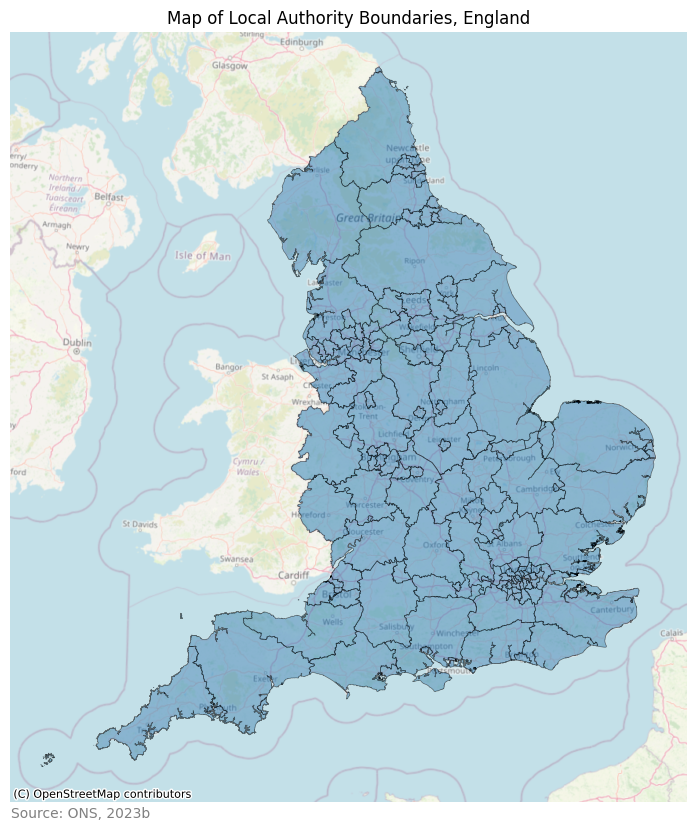

In [66]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the boundaries, make slightly transparent to see context beneath
final_df.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=0.5)

# Add OpenStreetMap basemap and make slightly paler. Use crs from dataframe
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, alpha=0.7, crs=final_df.crs.to_string())

# Set title
plt.title('Map of Local Authority Boundaries, England')

# Add source below the chart
plt.text(0.001, -0.02, 'Source: ONS, 2023b', transform=ax.transAxes, fontsize=10, color='gray')

# Turn off the axes
ax.axis('off')

# Save as .png for use in Policy Brief
#plt.savefig('Exports - Images/context_map.png')

# Show the plot
plt.show()

### 3.2. 'Raw' variables

Figure 3.2.1. presents choropleths of the 'raw' variables that are not included in the analysis, but give an idea of the spatial patterns in the data. There are higher proportions of under 4s in more urban LAs, particularly those that include major cities and towns or are within Greater London. Contrastingly, the proportion of the population aged 65 or over is highest around coastal areas that are typically more rural.

The spatial distribution of the total number of EYS and care home locations is overall similar across LAs. The highest numbers are again in the more urban LAs, particularly those around major cities and towns. However, the city-centre LAs such as Derby, Leicester and Nottingham have relatively fewer locations across both EYS and care homes. This likely reflects the more commercial nature of these LAs. Interestingly when comparing the spatial pattern between locations and proportions of each relevant population, there is no clearly visible relationship.

The results for EYS places and care home beds is largely similar to the total number of locations for each, with the noticable exception of EYS locations and places in Devon, where there appears to be fewer places compared to the number of locations as indicated by the lighter shade of green. This puts the number of places around the average for the dataset compared to the above average number of locations.

<div style="color: #2F5496; font-size: 14px; font-weight: bold;">
    Figure 3.2.1. Choropleth of "raw" variables by LA
</div>

<div style="color: #808080; margin-top: 5px">
    Data Source: CQC, 2024; Ofsted, 2023; ONS, 2023c
</div>

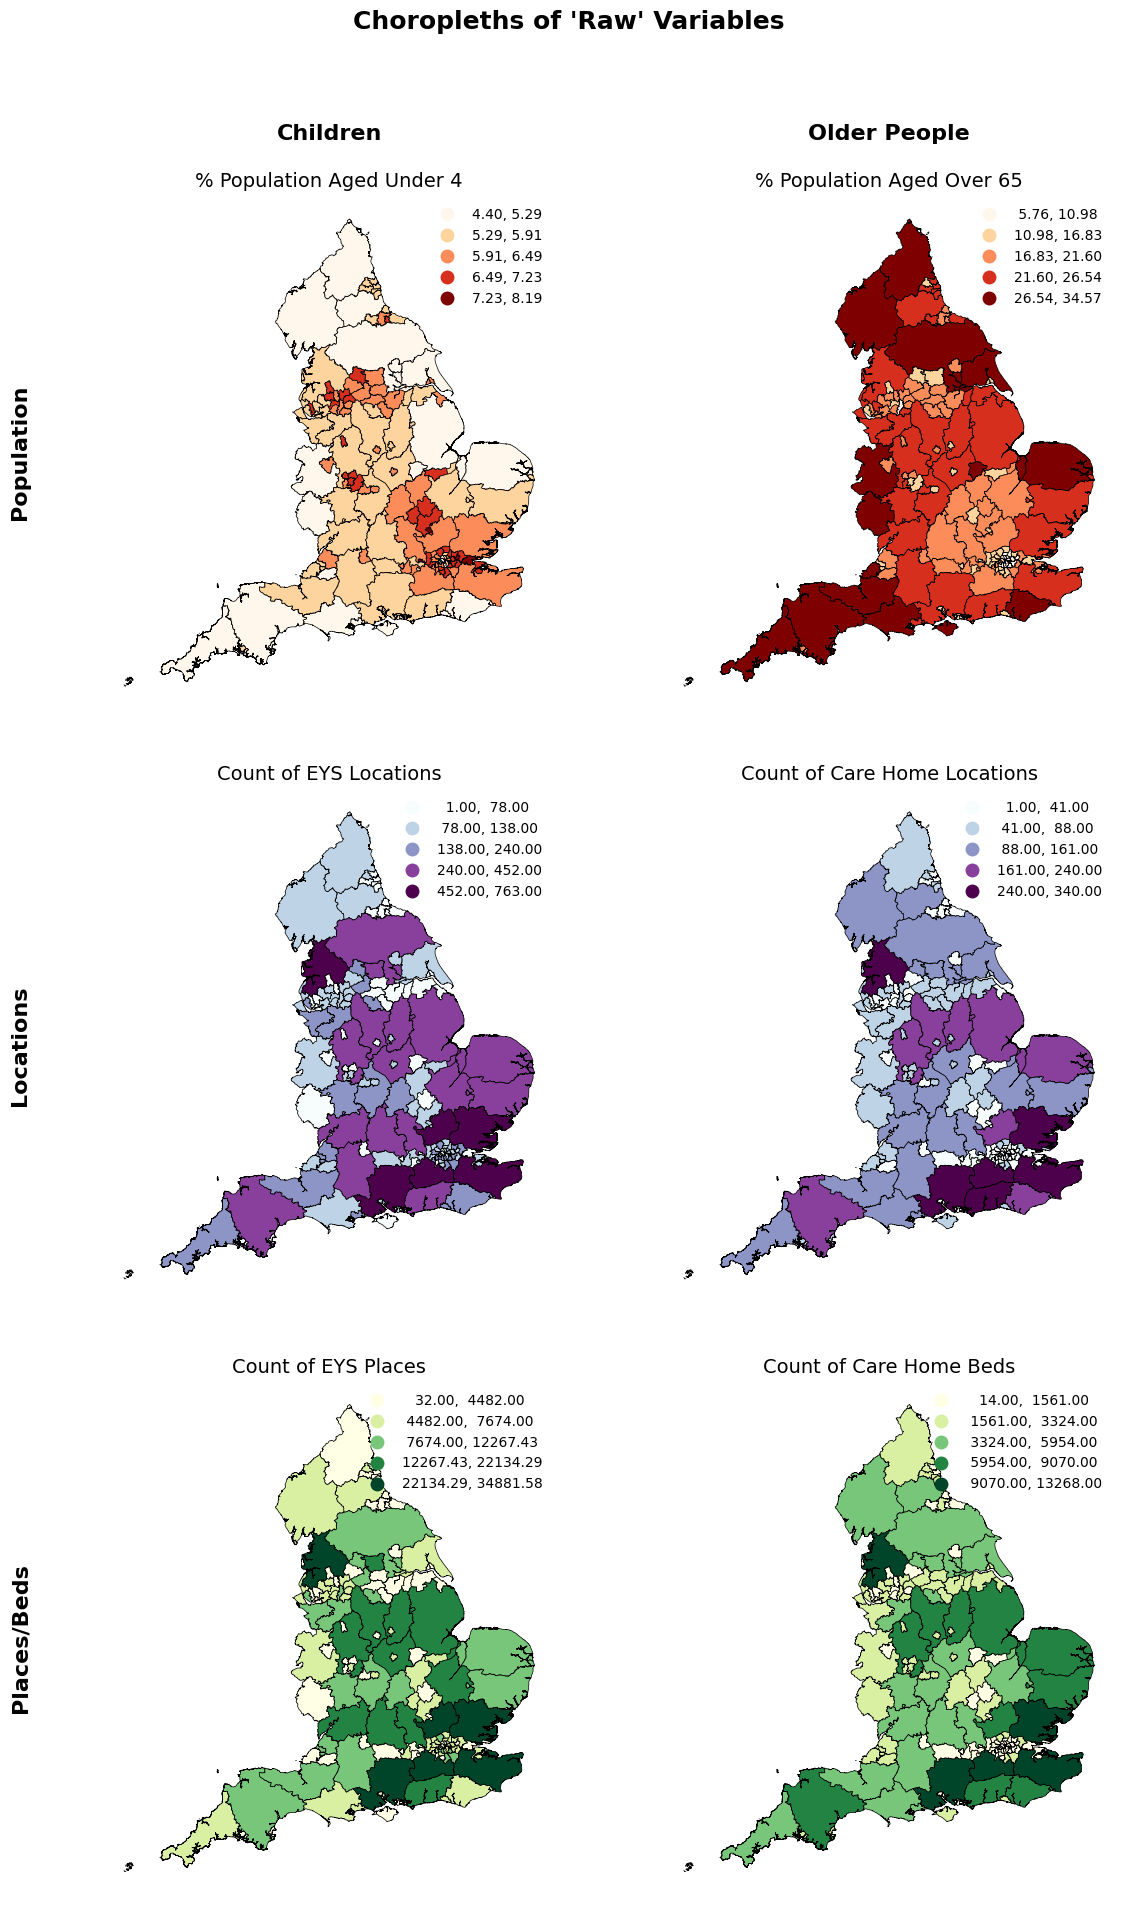

In [67]:
# Create a 2x3 grid of subplots for the maps of the "raw" variables
fig, axes = plt.subplots(3, 2, figsize=(12, 20))

# Plot each variable on a different subplot
### 0,0
choropleth.plot(ax=axes[0,0],                                                         # Identify subplot
                column='% Population Aged Under 4',                                    # Select variable to plot
                cmap='OrRd', linewidth=0.5, edgecolor='black',                        # Amend map visuals
                legend=True, scheme='natural_breaks', legend_kwds={'frameon':False})  # Amend legend

axes[0,0].set_title("% Population Aged Under 4", fontsize=14)                          # Add title
axes[0,0].set_axis_off()                                                              # Remove axis

### 0,1
choropleth.plot(ax=axes[0,1],
                column='% Population Aged Over 65',
                cmap='OrRd', linewidth=0.5, edgecolor='black',
                legend=True, scheme='natural_breaks', legend_kwds={'frameon':False})

axes[0,1].set_title("% Population Aged Over 65", fontsize=14)
axes[0,1].set_axis_off()

### 1,0
choropleth.plot(ax=axes[1,0],
                column='EYS Locations',
                cmap='BuPu', linewidth=0.5, edgecolor='black',
                legend=True, scheme='natural_breaks', legend_kwds={'frameon':False})

axes[1,0].set_title("Count of EYS Locations", fontsize=14)
axes[1,0].set_axis_off()

### 1,1
choropleth.plot(ax=axes[1,1],
                column='Care Home Locations',
                cmap='BuPu', linewidth=0.5, edgecolor='black',
                legend=True, scheme='natural_breaks', legend_kwds={'frameon':False})

axes[1,1].set_title("Count of Care Home Locations", fontsize=14)
axes[1,1].set_axis_off()

### 2,0
choropleth.plot(ax=axes[2,0],
                column='EYS Places',
                cmap='YlGn', linewidth=0.5, edgecolor='black',
                legend=True, scheme='natural_breaks', legend_kwds={'frameon':False})

axes[2,0].set_title("Count of EYS Places", fontsize=14)
axes[2,0].set_axis_off()

### 2,1
choropleth.plot(ax=axes[2,1],
                column='Care Home Beds',
                cmap='YlGn', linewidth=0.5, edgecolor='black',
                legend=True, scheme='natural_breaks', legend_kwds={'frameon':False})

axes[2,1].set_title("Count of Care Home Beds", fontsize=14)
axes[2,1].set_axis_off()



# Add a title to each row of subplots
for i, title in enumerate(["Population", "Locations", "Places/Beds"]):
    axes[i, 0].annotate(title, (0, 0.5), xytext=(-axes[i, 0].yaxis.labelpad -0, 0),
                        xycoords=axes[i, 0].yaxis.label, textcoords='offset points',
                        fontsize=16, ha='right', va='center', rotation=90, fontweight='bold')


# Add a title to each column of subplots
for j, title in enumerate(["Children", "Older People"]):
    axes[0, j].annotate(title, (0.5, 1), xytext=(0, 40),
                        xycoords='axes fraction', textcoords='offset points',
                        fontsize=16, ha='center', va='baseline', fontweight='bold')


# Add an overall title for the whole axes
fig.suptitle("Choropleths of 'Raw' Variables", fontsize=18, fontweight='bold')

# Show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=4.0, w_pad=4.0)
plt.show()

### 3.3. Features for analysis

The statistics and visualisations in this section include the features that will be used in the analysis. These are sometimes used in both 'raw' and standardised (Z-score) formats depending on the statistic or visualisation.

Figure 3.3.1. shows some simple descriptive statistics of the 'raw' version of the features. This highlights that the range of values are on vastly different scales, emphasising the importance of standardising the data. The range is smallest for the percentage of people aged under 4, with the 25th, 50th and 75th percentiles showing that the majority of the data lies around 6%.

There is also clearly a difference in the number of children to EYS locations and places compared to the number of older people to care home locations and beds. This is likely influenced by the fact most children attend an EYS, particularly in the year before starting school. By contrast, not all older people will want or need to live in a care home and so the number of people aged 65 and over to each care home location and bed is much higher. This is a limitation within this analysis and is discussed in more depth in the accompanying policy briefing.

Lastly, care homes are also generally larger than EYS locations, which could be influencing the higher number of older people to care home locations compared to children to EYS locations.

<div style="color: #2F5496; font-size: 14px; font-weight: bold;">
    Figure 3.3.1. Descriptive statistics of 'raw' features
</div>

<div style="color: #808080; margin-top: 5px">
    Data Source: CQC, 2024; Ofsted, 2023; ONS, 2023c; Author's calculations
</div>

In [68]:
# Descriptive statistics for "raw" version of features
final_df[['%U4', '%O65', 'U4:EYS Locs', 'U4:EYS Places', 'O65:CH Locs', 'O65:CH Beds']].describe()

,%U4,%O65,U4:EYS Locs,U4:EYS Places,O65:CH Locs,O65:CH Beds
count,151.00,151.00,151.00,151.00,151.00,151.00
mean,0.06,0.19,154.32,3.10,1129.40,28.72
std,0.01,0.06,50.54,0.91,522.09,11.80
min,0.04,0.06,76.57,1.49,512.12,16.14
25%,0.06,0.15,119.53,2.47,874.22,22.67
50%,0.06,0.19,140.57,2.86,1026.10,25.65
75%,0.06,0.23,182.29,3.59,1188.83,30.17
max,0.08,0.35,324.88,6.53,4101.00,105.70


Figure 3.3.2. illustrates the relationship between each population group and the relevant service location and beds/places ratios. This gives an early indication of how many LAs are potentially under- or over-served by different services, shown by the distance from the regression line.

For the "% Population Aged Under 4" charts, those above the line are potentially under-served and may benefit from additional provision being introduced. This is where the proportion of the population in the target age group is high but the number of EYS locations and places is low.

For the "% Population Aged Over 65" charts, the relationship is negative, meaning LAs with a higher percentage of older people have lower ratios of people to care home locations and beds. However, the charts show there is a cluster of outliers with very high ratios to the bottom right of the chart. These are all in central London, an issue that will be investigated further in section 4.

<div style="color: #2F5496; font-size: 14px; font-weight: bold;">
    Figure 3.3.2. Scatterplots of percentage of the population by age group compared to service locations and beds/places ratios, by LA
</div>

<div style="color: #808080; margin-top: 5px">
    Data Source: CQC, 2024; Ofsted, 2023; ONS, 2023c; Author's calculations
</div>

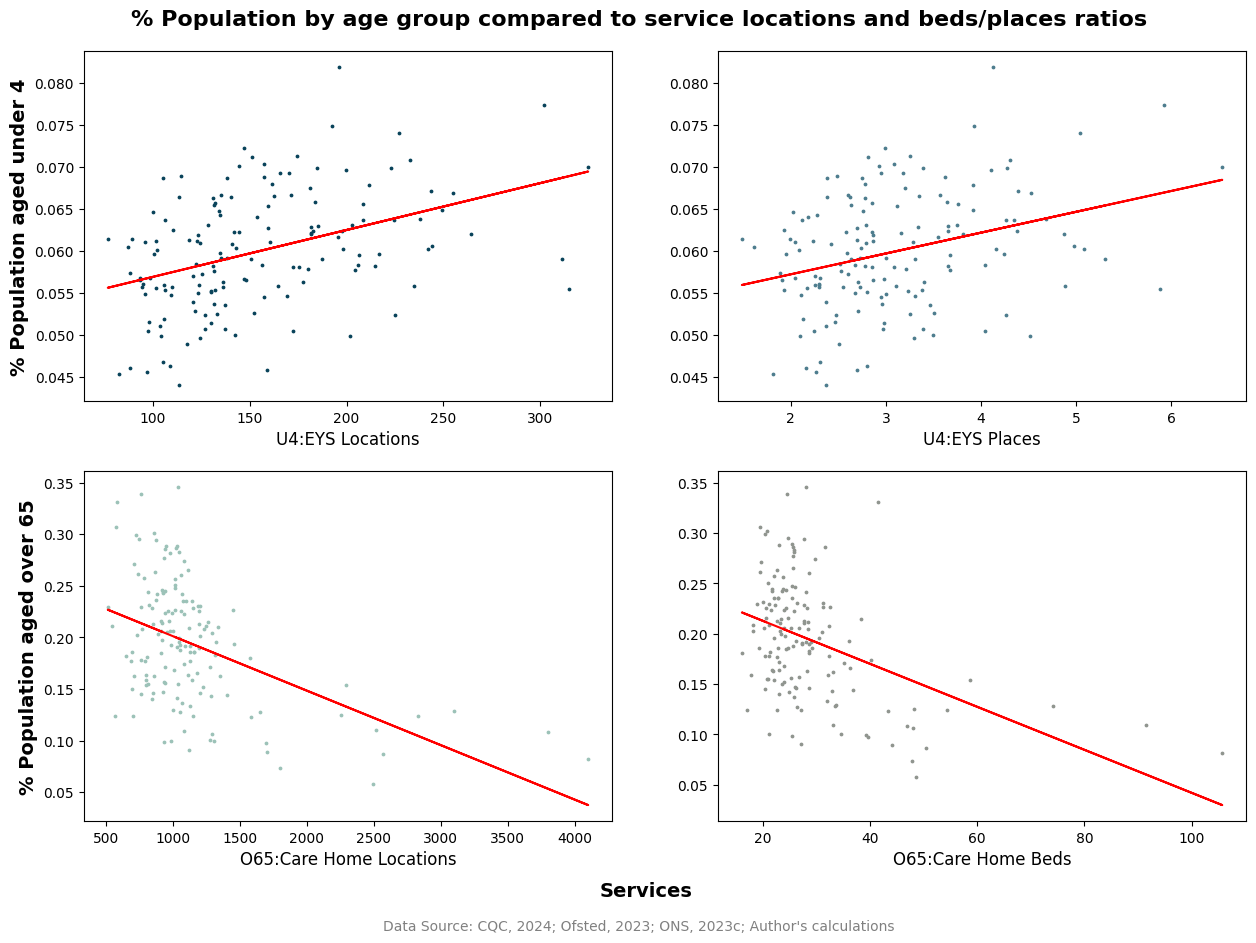

In [69]:
# Set up a figure with 2 rows and 2 columns for subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Add title, x-axis subtitle, and y-axis labels
plt.title('% Population by age group compared to service locations and beds/places ratios', 
          x=-0.15, y=2.25, fontweight='bold', fontsize=16)
fig.suptitle('Services', y=0.05, fontweight='bold', fontsize=14)
axs[0,0].set_ylabel('% Population aged under 4', fontweight='bold', fontsize=14)
axs[1,0].set_ylabel('% Population aged over 65', fontweight='bold', fontsize=14)


### U4, EYS Locs scatter
axs[0,0].scatter(x=final_df['U4:EYS Locs'], y=final_df['%U4'], s=3, c='#09435a') # add data and set colour
axs[0,0].set_xlabel('U4:EYS Locations', fontsize=12) # add axis label and set font

# Calculate the regression line
slope0, intercept0 = np.polyfit(final_df['U4:EYS Locs'], final_df['%U4'], 1)
regression_line0 = np.polyval([slope0, intercept0], final_df['U4:EYS Locs'])

# Add this to the chart
axs[0,0].plot(final_df['U4:EYS Locs'], regression_line0, color='red')


### U4, EYS Places scatter
axs[0,1].scatter(x=final_df['U4:EYS Places'], y=final_df['%U4'], s=3, c='#4e7d8e') # add data and set colour
axs[0,1].set_xlabel('U4:EYS Places', fontsize=12) # add axis label and set font

# Calculate the regression line
slope1, intercept1 = np.polyfit(final_df['U4:EYS Places'], final_df['%U4'], 1)
regression_line1 = np.polyval([slope1, intercept1], final_df['U4:EYS Places'])

# Add this to the chart
axs[0,1].plot(final_df['U4:EYS Places'], regression_line1, color='red')


### O65, CH Locs scatter
axs[1,0].scatter(x=final_df['O65:CH Locs'], y=final_df['%O65'], s=3, c='#9cc2b8') # add data and set colour
axs[1,0].set_xlabel('O65:Care Home Locations', fontsize=12) # add axis label and set font

# Calculate the regression line
slope2, intercept2 = np.polyfit(final_df['O65:CH Locs'], final_df['%O65'], 1)
regression_line2 = np.polyval([slope2, intercept2], final_df['O65:CH Locs'])

# Add this to the chart
axs[1,0].plot(final_df['O65:CH Locs'], regression_line2, color='red')


### O65, CH Beds scatter
axs[1,1].scatter(x=final_df['O65:CH Beds'], y=final_df['%O65'], s=3, c='#90958f') # add data and set colour
axs[1,1].set_xlabel('O65:Care Home Beds', fontsize=12) # add axis label and set font

# Calculate the regression line
slope3, intercept3 = np.polyfit(final_df['O65:CH Beds'], final_df['%O65'], 1)
regression_line3 = np.polyval([slope3, intercept3], final_df['O65:CH Beds'])

# Add this to the chart
axs[1,1].plot(final_df['O65:CH Beds'], regression_line3, color='red')


# Add a footnote with the data source and specify location on visual
plt.text(-0.15, -0.3,
         "Data Source: CQC, 2024; Ofsted, 2023; ONS, 2023c; Author's calculations",
         ha="center", va="center", transform=plt.gca().transAxes,
         fontsize=10, color="gray")


plt.show()

Figure 3.3.3. presents choropleths again, but this time using the features that will be used in the analysis. The population features are the same as before (figure 3.2.1.), but the provision is now shown as ratios.

The spatial distribution of the ratio of locations to beds/places presents a very different view compared to the raw counts in figure 3.2.1. LAs including large towns and cities have the highest ratio of children to EYS locations and places, with Wakefield, Doncaster and Rotherham being noticeably high ratios across both measures. Derby, Nottingham and Leicester also show high ratios as city-centre LAs.

By contrast, these areas all have a lower ratio of older people to care home locations and beds, as shown by the paler colour on the choropleth. This is partly influenced by the noticeable skewing of the data towards London, with all of the highest ratios for locations and beds being within London. This is an issue investigated further in section 4.

<div style="color: #2F5496; font-size: 14px; font-weight: bold;">
    Figure 3.3.3. Choropleths of 'raw' features for analysis, by LA
</div>

<div style="color: #808080; margin-top: 5px">
    Data Source: CQC, 2024; Ofsted, 2023; ONS, 2023c; Author's calculations
</div>

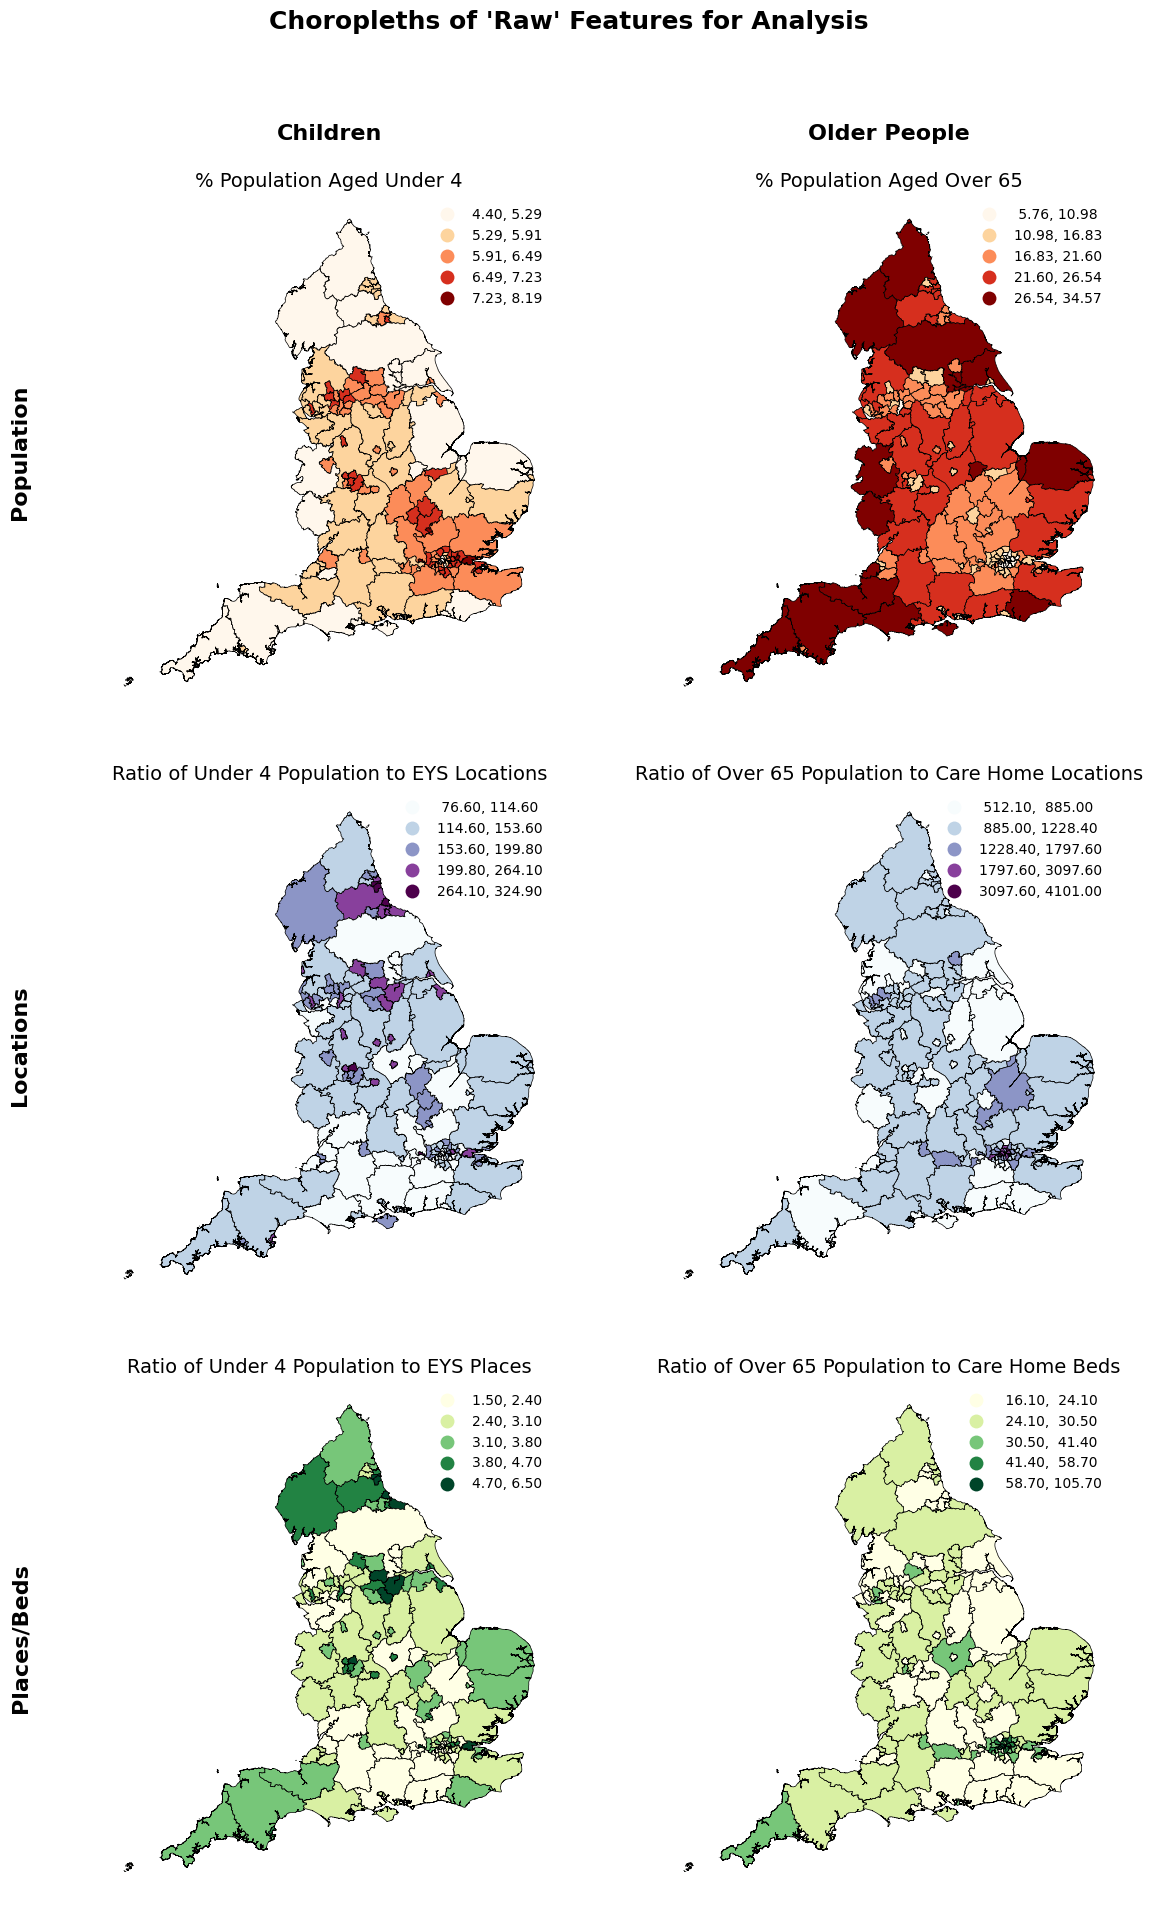

In [70]:
# Create a 2x3 grid of subplots for the maps of the features
fig, axes = plt.subplots(3, 2, figsize=(12, 20))

# Plot each feature on a different subplot
### 0,0
choropleth.plot(ax=axes[0,0],                                                         # Identify subplot
                column='% Population Aged Under 4',                                    # Select variable to plot
                cmap='OrRd', linewidth=0.5, edgecolor='black',                        # Amend map visuals
                legend=True, scheme='natural_breaks', legend_kwds={'frameon':False})  # Amend legend

axes[0,0].set_title("% Population Aged Under 4", fontsize=14)                          # Add title
axes[0,0].set_axis_off()                                                              # Remove axis

### 0,1
choropleth.plot(ax=axes[0,1],
                column='% Population Aged Over 65',
                cmap='OrRd', linewidth=0.5, edgecolor='black',
                legend=True, scheme='natural_breaks', legend_kwds={'frameon':False})

axes[0,1].set_title("% Population Aged Over 65", fontsize=14)
axes[0,1].set_axis_off()

### 1,0
choropleth.plot(ax=axes[1,0],
                column='Ratio of Under 4 Population to EYS Locations',
                cmap='BuPu', linewidth=0.5, edgecolor='black',
                legend=True, scheme='natural_breaks', legend_kwds={'frameon':False})

axes[1,0].set_title("Ratio of Under 4 Population to EYS Locations", fontsize=14)
axes[1,0].set_axis_off()

### 1,1
choropleth.plot(ax=axes[1,1],
                column='Ratio of Over 65 Population to Care Home Locations',
                cmap='BuPu', linewidth=0.5, edgecolor='black',
                legend=True, scheme='natural_breaks', legend_kwds={'frameon':False})

axes[1,1].set_title("Ratio of Over 65 Population to Care Home Locations", fontsize=14)
axes[1,1].set_axis_off()

### 2,0
choropleth.plot(ax=axes[2,0],
                column='Ratio of Under 4 Population to EYS Places',
                cmap='YlGn', linewidth=0.5, edgecolor='black',
                legend=True, scheme='natural_breaks', legend_kwds={'frameon':False})

axes[2,0].set_title("Ratio of Under 4 Population to EYS Places", fontsize=14)
axes[2,0].set_axis_off()

### 2,1
choropleth.plot(ax=axes[2,1],
                column='Ratio of Over 65 Population to Care Home Beds',
                cmap='YlGn', linewidth=0.5, edgecolor='black',
                legend=True, scheme='natural_breaks', legend_kwds={'frameon':False})

axes[2,1].set_title("Ratio of Over 65 Population to Care Home Beds", fontsize=14)
axes[2,1].set_axis_off()



# Add a title to each row of subplots
for i, title in enumerate(["Population", "Locations", "Places/Beds"]):
    axes[i, 0].annotate(title, (0, 0.5), xytext=(-axes[i, 0].yaxis.labelpad -0, 0),
                        xycoords=axes[i, 0].yaxis.label, textcoords='offset points',
                        fontsize=16, ha='right', va='center', rotation=90, fontweight='bold')


# Add a title to each column of subplots
for j, title in enumerate(["Children", "Older People"]):
    axes[0, j].annotate(title, (0.5, 1), xytext=(0, 40),
                        xycoords='axes fraction', textcoords='offset points',
                        fontsize=16, ha='center', va='baseline', fontweight='bold')


# Add an overall title for the whole axes
fig.suptitle("Choropleths of 'Raw' Features for Analysis", fontsize=18, fontweight='bold')

# Show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=4.0, w_pad=4.0)
plt.show()

Moving on, figure 3.3.4. shows the same descriptive statistics as before but using the standardised (Z-score) version of the features. Here the range is much more comparable across the features, with some outliers on the top end as shown by the higher maximum compared to the minimum Z-score. This is illustrated more clearly in figure 3.3.5.

<div style="color: #2F5496; font-size: 14px; font-weight: bold;">
    Figure 3.3.4. Descriptive statistics of Z-score features
</div>

<div style="color: #808080; margin-top: 5px">
    Data Source: CQC, 2024; Ofsted, 2023; ONS, 2023c; Author's calculations
</div>

In [71]:
# Descriptive statistics for Z-Score version of features
final_df[['%U4z', '%O65z', 'U4:EYS Locsz', 'U4:EYS Placesz', 'O65:CH Locsz', 'O65:CH Bedsz']].describe()

,%U4z,%O65z,U4:EYS Locsz,U4:EYS Placesz,O65:CH Locsz,O65:CH Bedsz
count,151.00,151.00,151.00,151.00,151.00,151.00
mean,-0.00,-0.00,0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.29,-2.33,-1.54,-1.78,-1.19,-1.07
25%,-0.63,-0.69,-0.69,-0.70,-0.49,-0.51
50%,-0.02,-0.02,-0.27,-0.26,-0.20,-0.26
75%,0.68,0.61,0.56,0.55,0.11,0.12
max,3.15,2.59,3.39,3.80,5.71,6.55


Figure 3.3.5. is a boxplot of the Z-scores of the features. There are extreme outliers on the top end of each feature, as illustrated by the circles lying beyond the upper extreme (horizontal line, or end of the whisker). The '%U4z' and '%O65z' features have the largest range between the upper and lower extremes, as well as the largest range between the upper and lower quartiles, highlighting the greatest spread in the data. However, these variables have the fewest extreme outliers and these outliers are also relatively close to the upper extreme compared to the other features.

By contrast, the 'O65:CH Locsz' and 'O65:CH Bedsz' features have the smallest range between the upper and lower extremes, as well as the smallest range between the upper and lower quartile. However, these features have the most extreme outliers both in terms of quantity and distance from the upper extreme. This confirms the findings in figure 3.3.2. that was causing the negative gradient regression line.

<div style="color: #2F5496; font-size: 14px; font-weight: bold;">
    Figure 3.3.5. Boxplot of Z-Score features, by LA
</div>

<div style="color: #808080; margin-top: 5px">
    Data Source: CQC, 2024; Ofsted, 2023; ONS, 2023c; Author's calculations
</div>

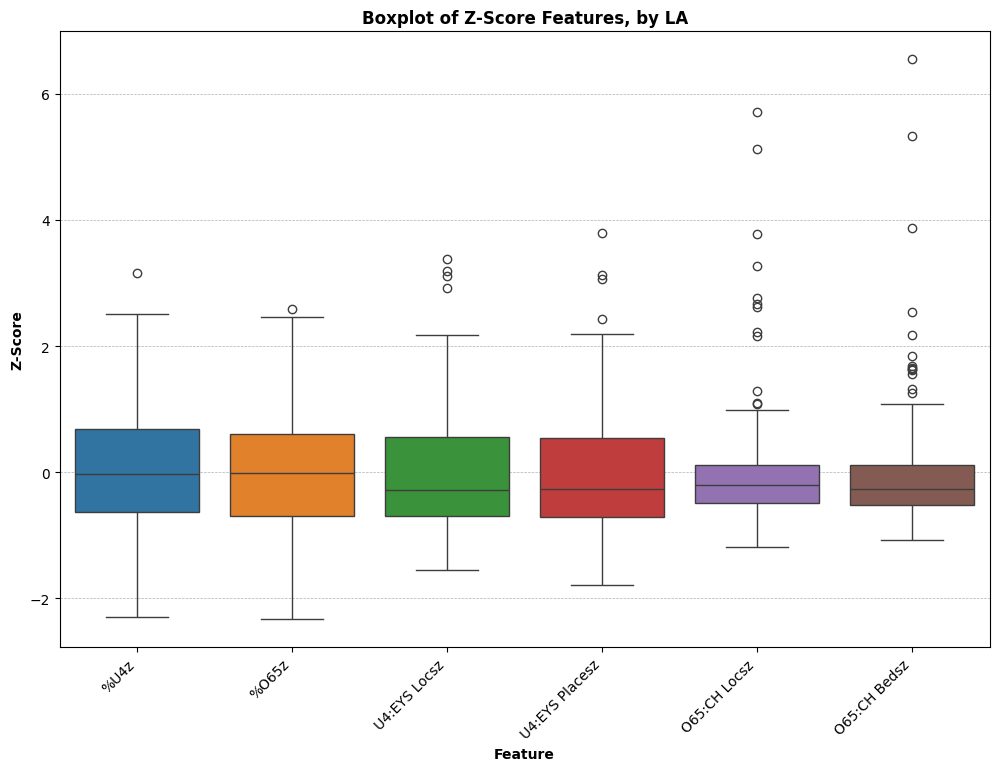

In [72]:
# Box plot of Z-score features
plt.figure(figsize=(12, 8))
sns.boxplot(data=final_df[['%U4z', '%O65z', 'U4:EYS Locsz', 'U4:EYS Placesz', 'O65:CH Locsz', 'O65:CH Bedsz']])
plt.title('Boxplot of Z-Score Features, by LA', fontweight='bold')
plt.ylabel('Z-Score', fontweight='bold')
plt.xlabel('Feature', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
plt.show()

## 4. Analysis & Results

### 4.1. Establishing feature collinearity

Before building the K-means clustering model, the relationship between the features must be further understood. To begin, the features are isolated into a new dataframe, with the CTYUA22CD converted into the index. This dataframe will be used for the subsequent analysis in this section. The Z-score version of the features are used as they are standardised and therefore comparable.

In [73]:
# Isolate the features to include in the K-means modelling
kmeanData = final_df.set_index('CTYUA22CD')[[
    '%U4z', '%O65z', 'U4:EYS Locsz', 'U4:EYS Placesz', 'O65:CH Locsz', 'O65:CH Bedsz']].copy()

Next, a correlation matrix (figure 4.1.1.) is created to check for collinearity and illustrate the relationship between the features going into more depth than the visualisations in Section 3. Strong collinearity (positive or negative) is not necessarily an issue when building a clustering model, but it is important to understand the features and their relationships in more depth before commencing the more advanced analysis.

Figure 4.1.1. shows collinearity between the location and beds/places ratios for the respective age groups. This is to be expected as generally more locations means more places/beds. There is some collinearity between the proportion of the population aged under 4 and the EYS ratio features, whilst the opposite is true for the over 65 population and care home ratios, as was found in Section 3.

<div style="color: #2F5496; font-size: 14px; font-weight: bold;">
    Figure 4.1.1. Correlation matrix heatmap of Z-Score features
</div>

<div style="color: #808080; margin-top: 5px">
    Data Source: CQC, 2024; Ofsted, 2023; ONS, 2023c; Author's calculations
</div>

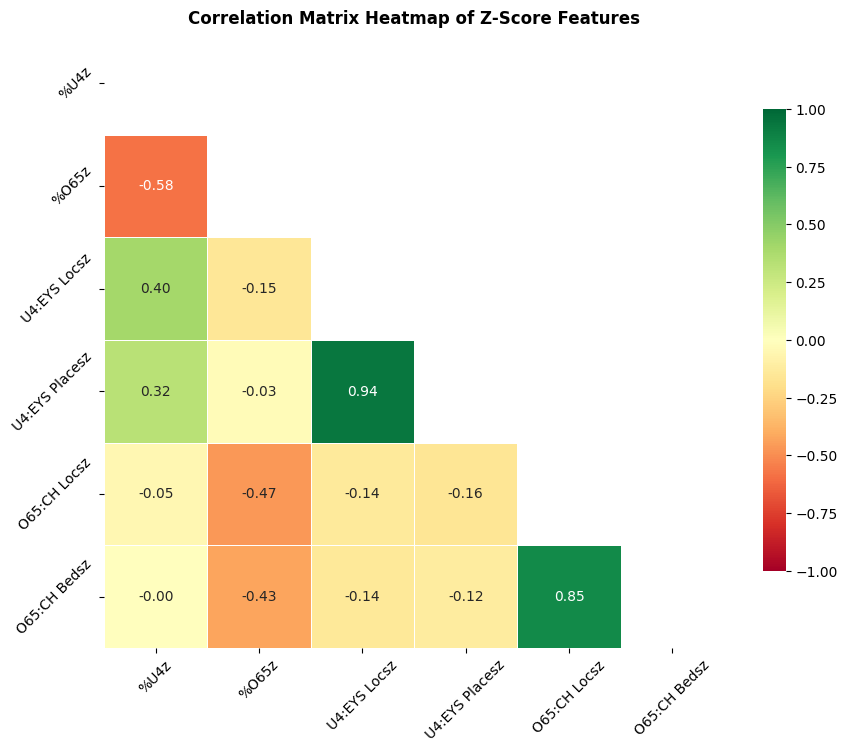

In [74]:
# Generate correlation matrix of features
correlation_matrix = kmeanData.corr()

# Generate a mask for the diagonal cells
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='RdYlGn', annot=True, 
            fmt=".2f", mask=mask, vmin=-1, vmax=1, cbar_kws={"shrink": 0.75}, linewidth=.5)
plt.title('Correlation Matrix Heatmap of Z-Score Features', fontweight='bold')

# Rotate axis labels
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Save as .png for use in Policy Brief
#plt.savefig('Exports - Images/correlation_matrix_heatmap.png')

plt.show()

Another way of viewing this is as a scatter matrix (figure 4.1.2.) which gives a clearer view of the spread across the datapoints, as well as the distribution of data for each feature (shown on the diagonal). As mentioned in section 2.6., the features are normally distributed with some tails due to outliers, but showing that Z-scores as a standardisation approach is acceptable to use.

<div style="color: #2F5496; font-size: 14px; font-weight: bold;">
    Figure 4.1.2. Scatter matrix of Z-Score features
</div>

<div style="color: #808080; margin-top: 5px">
    Data Source: CQC, 2024; Ofsted, 2023; ONS, 2023c; Author's calculations
</div>

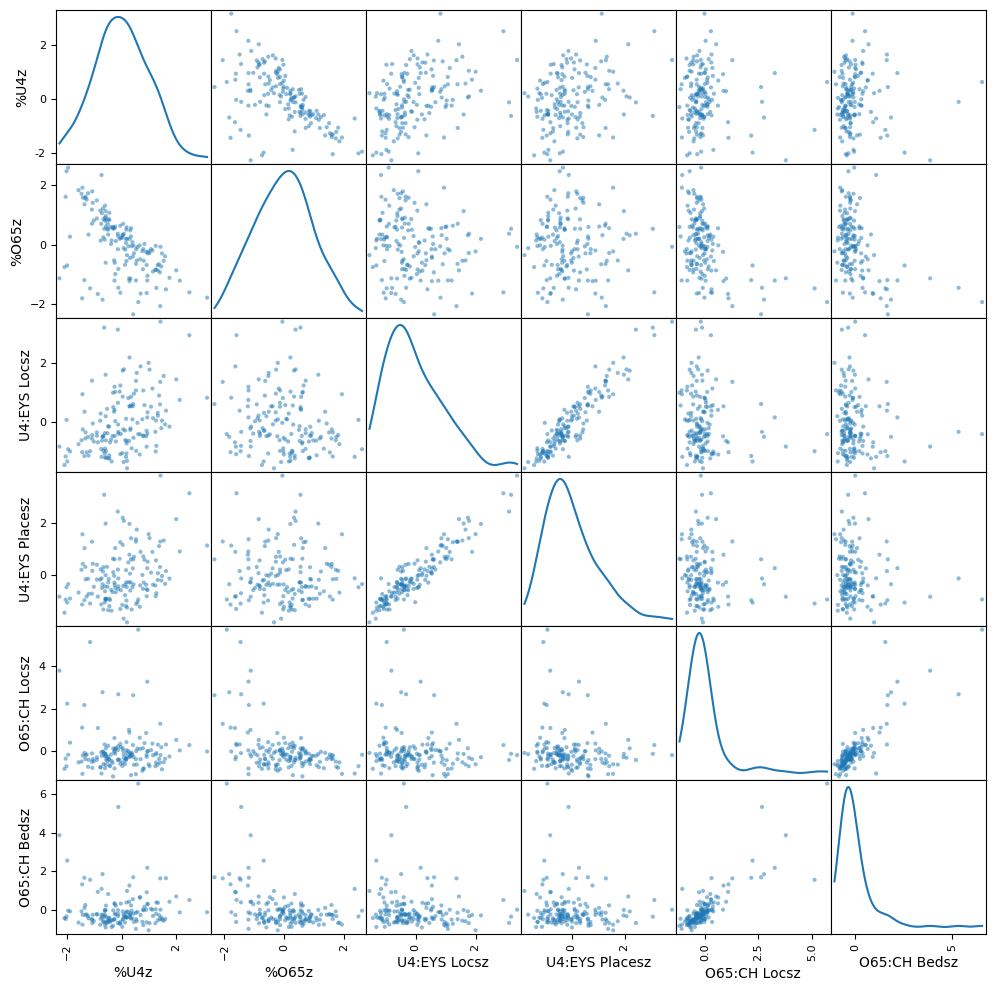

In [75]:
# Correlation matrix
corr_matrix = pd.plotting.scatter_matrix(kmeanData, alpha=0.5, figsize=(12, 12), diagonal='kde')

### 4.2. Identifying the optimal number of K-means clusters

There are a number of ways to determine the optimal number of K-means clusters; however, here the elbow method is used. This tests a range of K values (1 to 10) to identify where the distortions drop significantly between clusters, thus creating an "elbow" in the chart (figure 4.2.1.). The yellow line on figure 4.2.1. highlights that for this data, the optimal number of K clusters is 4.

It should be noted that 3 clusters were also tested during this analysis given the visible drop in the chart here also, but this model performed worse overall compared to the 4 cluster version. 

In [76]:
distortions = [] # Empty list for distortion data
K = range(1,10) # K value range for cluster tests
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=10) # Build K-Means clustering model
    kmeanModel.fit(kmeanData) # Fit model to the data
    distortions.append(kmeanModel.inertia_) # Add results to distortions list

<div style="color: #2F5496; font-size: 14px; font-weight: bold;">
    Figure 4.2.1. Elbow chart showing optimal k (number of clusters)
</div>

<div style="color: #808080; margin-top: 5px">
    Data Source: Author's calculations
</div>

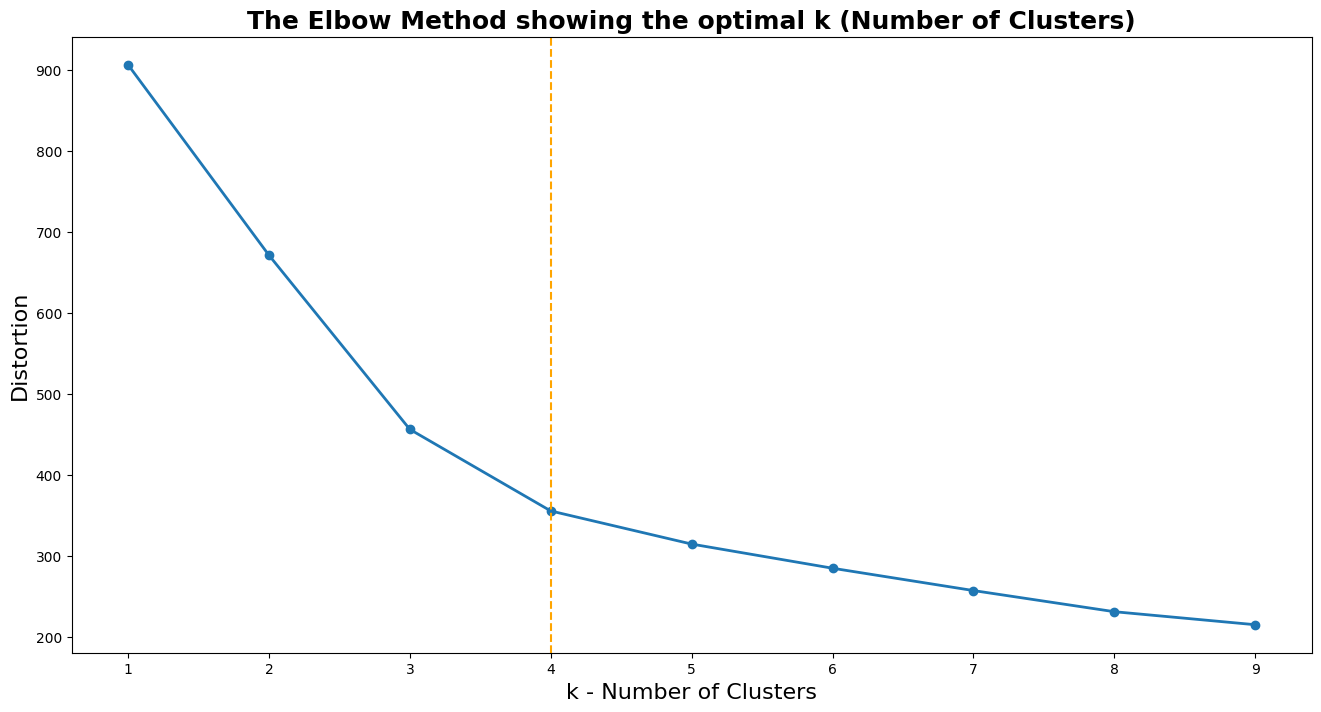

In [77]:
# Elbow chart
plt.figure(figsize=(16,8))
plt.plot(K, distortions, ls='-', lw=2, marker='o')
plt.xlabel('k - Number of Clusters', fontsize=16)
plt.ylabel('Distortion', fontsize=16)
plt.title('The Elbow Method showing the optimal k (Number of Clusters)', fontsize=18, fontweight='bold')
plt.axvline(x=4, color='Orange', linestyle='--')  # Adding a vertical dotted line at x=4

# Save as .png for use in Policy Brief
#plt.savefig('Exports - Images/elbow_chart.png')

plt.show()

### 4.3. K-means clustering model

A K-means clustering model can now be run using the parameters outlined in the previous section. The model will calculate 4 clusters, and several pieces of information from the model will be stored for further testing and visualisation.

In [78]:
# Determine number of clusters for the model and number of times the model is run from different centroid seeds
kmeans = KMeans(n_clusters=4, n_init=10)

In [79]:
# Fit the model above to the data
kmeans.fit(kmeanData)

KMeans(n_clusters=4, n_init=10)

In [80]:
# Get cluster labels and distances from cluster centers
kmeans_labels = kmeans.labels_
kmeans_centres = kmeans.cluster_centers_

In [81]:
# Calculate distances from each data point to its assigned cluster center
distances = np.linalg.norm(kmeanData - kmeans_centres[kmeans_labels], axis=1)

# Add cluster labels and distances to the kmean dataframe
kmeanData['Cluster'] = kmeans_labels
kmeanData['Distance'] = distances

A check of the number iterations that were performed before the model stabilised shows that this model performed well with a low number of iterations, which is preferable over more iterations.

In [82]:
# Get the number of iterations
kmeans.n_iter_

6

The silhouette score, or silhouette coefficient, indicates the performance of the model in terms of overlapping clusters or misassignment of clusters. The closer the score is to 1, the better the model, whilst 0 indicates overlapping clusters, and negative values imply that incorrect clusters have been assigned (scikit-learn, 2024). The silhouette score for this model is acceptable, but highlights the model is not perfect.

In [83]:
metrics.silhouette_score(X=kmeanData, labels=kmeans_labels) #specify the data and the labels

0.38730634175097434

It is also important to check the distribution of LAs in each cluster. It is unlikely that each cluster will contain the same number of LAs, but a K-means clustering model with the majority of LAs in one cluster would likely need reviewing. This model has a small number of LAs in one cluster, but as discussed in the policy briefing this is a sensible and justifiable result in these circumstances.

In [84]:
# Count the occurrences of each cluster label
cluster_counts = kmeanData['Cluster'].value_counts().reset_index()

# Rename the columns to 'Cluster' and 'Count'
cluster_counts.columns = ['Cluster', 'Count']

# Sort the DataFrame by cluster label
cluster_counts.sort_values(by='Cluster', inplace=True)
cluster_counts

,Cluster,Count
0,0,57
2,1,33
1,2,51
3,3,10


It is also important to understand the statistics behind the model, and ensure that the model is robust. ANOVA tables show the significance of each feature, as well as its F-statistic. All of the features are statistically significant as shown in figure 4.3.1., and the range in F-statistic is relatively small compared to when the K-means model was re-run with different cluster numbers. However, the age features have a lower F-statistic than the other features such that these are contributing less to the model overall.

In [85]:
# Create a copy of the kmeanData df including features and cluster labels
df_for_ANOVA = kmeanData.copy()

# Dictionary mapping original column names to ASCII compliant names
ascii_column_names = {
    '%U4z': 'PC_U4z',
    '%O65z': 'PC_O65z',
    'U4:EYS Locsz': 'U4_EYS_Locsz',
    'U4:EYS Placesz': 'U4_EYS_Placesz',
    'O65:CH Locsz': 'O65_CH_Locsz',
    'O65:CH Bedsz': 'O65_CH_Bedsz',
    'Cluster': 'Cluster',
    'Distance': 'Distance'
}

# Rename columns
df_for_ANOVA = df_for_ANOVA.rename(columns=ascii_column_names)

# Perform ANOVA for each feature
anova_results = []
for column in df_for_ANOVA.columns[:-2]:  # Exclude 'Cluster' and 'Distance' columns
    formula = f"{column} ~ C(Cluster)"
    model = ols(formula, data=df_for_ANOVA).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    anova_results.append((column, anova_table))

<div style="color: #2F5496; font-size: 14px; font-weight: bold;">
    Figure 4.3.1. ANOVA tables for features in the K-means cluster model
</div>

<div style="color: #808080; margin-top: 5px">
    Data Source: Author's calculations
</div>

In [86]:
# Print ANOVA tables in a formatted way
for column, table in anova_results:
    print(f"ANOVA Table for '{column}':")
    print(tabulate(table, headers='keys', tablefmt='pretty'))
    print()

ANOVA Table for 'PC_U4z':
+------------+-------------------+-------+-------------------+------------------------+
|            |      sum_sq       |  df   |         F         |         PR(>F)         |
+------------+-------------------+-------+-------------------+------------------------+
| C(Cluster) | 73.97417079222865 |  3.0  | 47.05868675612382 | 2.2326909650674807e-21 |
|  Residual  | 77.02582920777132 | 147.0 |        nan        |          nan           |
+------------+-------------------+-------+-------------------+------------------------+

ANOVA Table for 'PC_O65z':
+------------+-------------------+-------+-------------------+------------------------+
|            |      sum_sq       |  df   |         F         |         PR(>F)         |
+------------+-------------------+-------+-------------------+------------------------+
| C(Cluster) | 87.32843117619302 |  3.0  | 67.20571216761822 | 2.0239329302714326e-27 |
|  Residual  | 63.67156882380687 | 147.0 |        nan        |    

The boxplot below (figure 4.3.2.) shows the distribution of each LA from the cluster centre to which it has been assigned, and helps to identify any outliers. There are a few extreme outliers at the top end for each cluster, but the majority of the data falls within the upper and lower quartiles. 

Cluster 0 has the most outliers but these are fairly close to the upper extreme. This cluster has a relatively low mean and the smallest range between the upper and lower quartiles. This shows that most LAs in this cluster are near to the centre despite the outliers on the top end.

Cluster 1 only has one outliers, but has the largest range between the upper and lower extremes and quartiles, suggesting some variance in the results. However, the mean is still fairly low, highlighting that LAs in this cluster mostly have values closer to the cluster centre.

Cluster 2, has the lowest mean and fairly small range between the upper and lower quartiles. There are two outliers on the top end, but overall this cluster performs well.

Cluster 3 has the highest mean and one extreme outlier on the top end, but does have a relatively small range between the quartiles. As highlighted above, this cluster has the fewest LAs within it and as shown in the visualisations in section 4.4. all the LAs in this cluster are in London. This issue is discussed in depth in the policy briefing.

<div style="color: #2F5496; font-size: 14px; font-weight: bold;">
    Figure 4.3.2. Boxplot of distance from cluster centres
</div>

<div style="color: #808080; margin-top: 5px">
    Data Source: Author's calculations
</div>

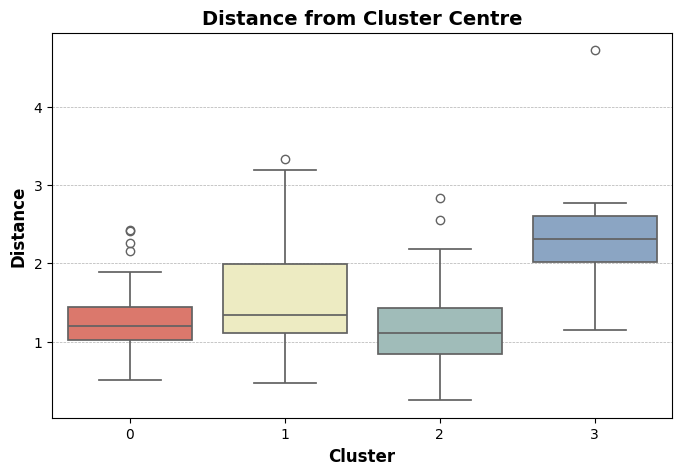

In [87]:
palette = ['#ed6a5a','#f4f1bb','#9bc1bc', '#81a4cd']

# Plot boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=kmeanData, x="Cluster", y="Distance", hue="Cluster", legend=False, palette=palette, linewidth=1.25)
plt.title('Distance from Cluster Centre', fontsize=14, fontweight='bold')
plt.xlabel('Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Distance', fontsize=12, fontweight='bold')
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)

# Save as .png for use in Policy Brief
#plt.savefig('Exports - Images/distance_from_cluster_centres.png')

plt.show()

To present the final cluster centres, the results must be transformed into a useable dataframe.

In [88]:
# Variable names
variable_names = ['%U4z', '%O65z', 'U4:EYS Locsz', 'U4:EYS Placesz', 'O65:CH Locsz', 'O65:CH Bedsz']

# Reshape the cluster centres array to match variable names
cluster_centres_reshaped = kmeans_centres.T

# Create a list to store the data
data = []

# Iterate through each cluster and variable, and append the data
for i, cluster_centre in enumerate(cluster_centres_reshaped):
    for j, centre in enumerate(cluster_centre):
        data.append([j, variable_names[i], centre])

# Create Cluster centres dataframe
df_cluster_centres = pd.DataFrame(data, columns=['Cluster Number', 'Feature Name', 'Centre'])

These clusters centres can then be used to present, by feature, each cluster which makes it easier to identify what each cluster represents. Figure 4.3.3. illstrates these results, with the below discussion developing pen portraits for each cluster. These pen portraits are used and discussed further in the policy briefing.

Cluster 0 has an above average proportion of the population aged under 4, but all other features are around the average. This implies there is a large target under 4 population in these LAs but provision is currently in line with the average. This cluster is "Young areas with adequate provision".

Cluster 1 has an above average proportion of the population aged under 4 as well as EYS ratios for both locations and places. This implies there are a large number of children in these areas compared to the average across all LAs, and that current provision is poor with more children to each EYS location and place. This cluster is "EYS opportunity".

Cluster 2 has an above average proportion of the population aged over 65, whilst having a below average proportion of children. The ratio features are all slightly below average. These are areas with provision in line with the average despite the older population. This cluster is "Older areas with adequate provision".

Cluster 3 shows significantly above average ratios for older people to care home locations and beds. This implies provision is significantly lacking in these areas. Meanwhile the proportion of the population over 65 is actually very below average, but the population that does live in these areas is lacking services. This cluster is "Care home opportunity".

<div style="color: #2F5496; font-size: 14px; font-weight: bold;">
    Figure 4.3.3. K-means cluster model centres by feature
</div>

<div style="color: #808080; margin-top: 5px">
    Data Source: Author's calculations
</div>

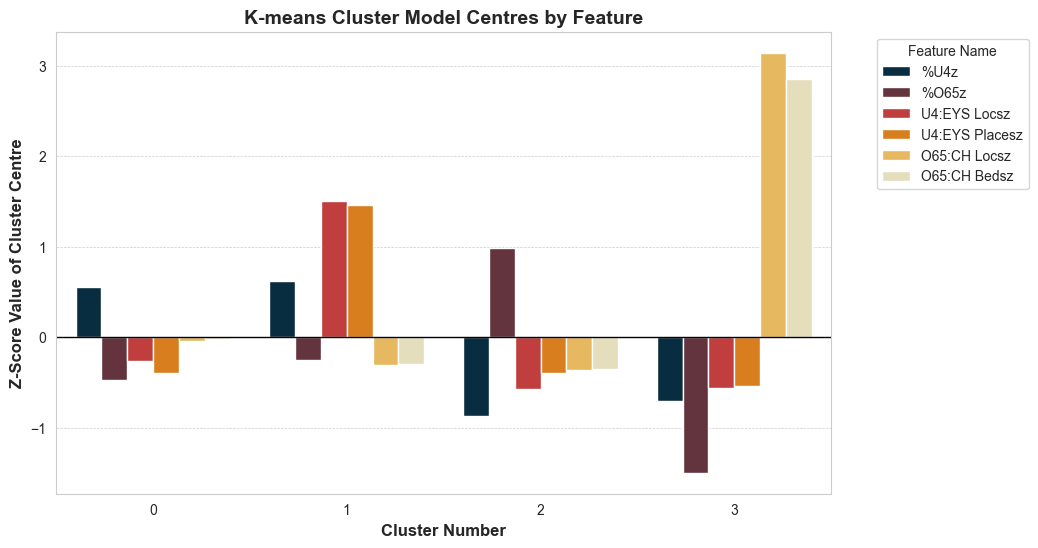

In [89]:
palette = ['#003049','#6b2c39','#d62828','#f77f00','#fcbf49','#eae2b7']

# Plot the bar chart
plt.figure(figsize=(10, 6))

# Set seaborn style
sns.despine()
sns.set_style("whitegrid")

# Add data and format
sns.barplot(data=df_cluster_centres, x='Cluster Number', y='Centre', hue='Feature Name', palette=palette)
plt.title('K-means Cluster Model Centres by Feature', fontsize=14, fontweight='bold')
plt.xlabel('Cluster Number', fontsize=12, fontweight='bold')
plt.ylabel('Z-Score Value of Cluster Centre', fontsize=12, fontweight='bold')
plt.legend(title='Feature Name', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add black line behind the x-axis and show grid for ease of reading
plt.axhline(0, color='black', linewidth=1)
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)

# Save as .png for use in Policy Brief
#plt.savefig('Exports - Images/cluster_centres_by_feature.png')

plt.show()

### 4.4. Visualising results

The resulting clusters can be visualised on a map to highlight any spatial patterns that have been found in the data. Figure 4.4.1. shows that cluster 3 ("Care home opportunity"), the smallest cluster as discussed above, contains only LAs in London.

Across the other clusters, there is more geographic variation. However, cluster 2 ("Older areas with adequate provision") covers more geographically large LAs, which primarily include large amounts of rural land such as North Yorkshire, Derbyshire and Devon. In contrast, Cluster 1 ("EYS opportunity") includes a number of mostly urban LAs, such as Derby and Leicester, as well as areas known for their large young populations, like Bradford (CBMDC, 2024).

Cluster 0 ("Young areas with adequate provision") is perhaps the most geographically varied covering rural-urban mix LAs such as Essex, Bedfordshire and Leeds, as well as mostly urban LAs such as those around outer London and City of Bristol.

In [90]:
# Reset index to get CTYUA22CD as a column for merging
kmeanData.reset_index(inplace=True)

In [91]:
# Add K-means clustering results to final_df for visualising
final_df = pd.merge(final_df, kmeanData[['CTYUA22CD', 'Cluster', 'Distance']], on='CTYUA22CD', how='left')

<div style="color: #2F5496; font-size: 14px; font-weight: bold;">
    Figure 4.4.1. Map of K-means cluster model results
</div>

<div style="color: #808080; margin-top: 5px">
    Data Source: Author's calculations
</div>

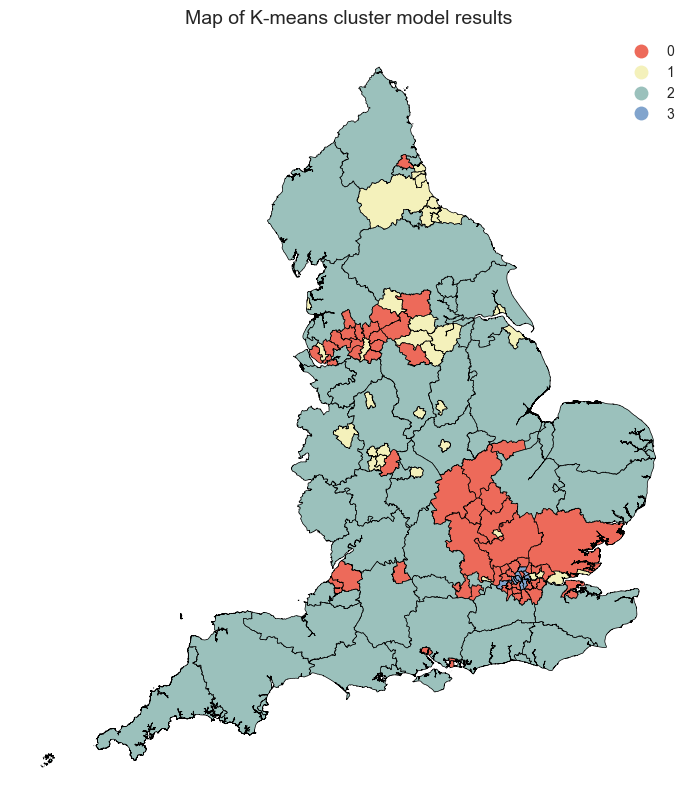

In [92]:
fig, axes = plt.subplots(figsize=(12, 10))

# Plot clusters
cmap = clrs.ListedColormap(['#ed6a5a','#f4f1bb','#9bc1bc', '#81a4cd'])
final_df.plot(ax=axes,
              column='Cluster',
              categorical=True,
              cmap=cmap,
              linewidth=0.5, edgecolor='black',
              legend=True, legend_kwds={'frameon':False})

axes.set_title("Map of K-means cluster model results", fontsize=14)
axes.set_axis_off()

# Save as .png for use in Policy Brief
#plt.savefig('Exports - Images/map_cluster_results.png')

# Show the plot
plt.show()

To provide further clarity on cluster 3, figure 4.4.2. shows a focused map of the LAs included in this cluster. This is discussed further in the policy briefing.

In [93]:
Cluster_London = final_df[final_df['Cluster'] == 3]

<div style="color: #2F5496; font-size: 14px; font-weight: bold;">
    Figure 4.4.2. Map of cluster containing London LAs only
</div>

<div style="color: #808080; margin-top: 5px">
    Data Source: Author's calculations
</div>

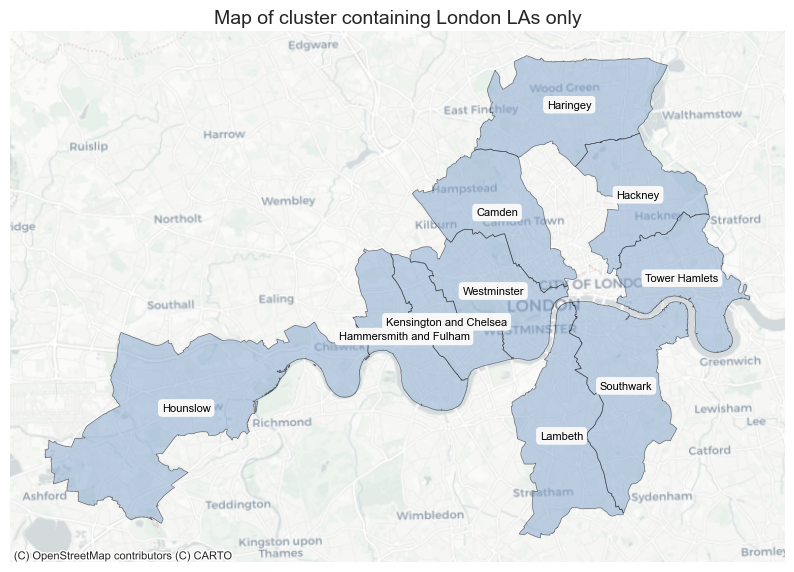

In [94]:
fig, ax = plt.subplots(1,figsize=(10,10))
Cluster_London.plot(ax = ax, edgecolor = 'black', linewidth = 0.5, alpha = 0.5, color='#81a4cd')
cx.add_basemap(ax, crs = Cluster_London.crs, source=cx.providers.CartoDB.Positron)

# Loop through each polygon and add label
for idx, row in Cluster_London.iterrows():
    centroid_x, centroid_y = row.geometry.centroid.x, row.geometry.centroid.y
    bbox_props = dict(boxstyle="round,pad=0.3", fc="#F7F7F7", lw=0.5)
    ax.annotate(text=row['CTYUA22NM'], xy=(centroid_x, centroid_y), xycoords='data', ha='center', va='center',
                fontsize=8, color='black', bbox=bbox_props)

ax.set_title("Map of cluster containing London LAs only", fontsize=14)
ax.set_axis_off()

# Save as .png for use in Policy Brief
#plt.savefig('Exports - Images/map_London_cluster.png')

plt.show()

Simple descriptives confirm the difference between the London cluster and the dataset as a whole as being driven by low numbers of care homes in these LAs.

In [95]:
Cluster_London.describe()

,U4,%U4,O65,%O65,CH Locs,CH Beds,EYS Locs,EYS Places,U4:EYS Locs,U4:EYS Places,...,U4z,O65z,%U4z,%O65z,U4:EYS Locsz,U4:EYS Placesz,O65:CH Locsz,O65:CH Bedsz,Cluster,Distance
count,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,...,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00
mean,13378.50,0.06,24177.30,0.11,9.40,421.20,105.00,5105.52,125.89,2.61,...,-0.47,-0.72,-0.71,-1.50,-0.56,-0.54,3.14,2.85,3.00,2.43
std,4521.43,0.01,4929.80,0.03,3.37,140.85,23.53,1411.07,30.59,0.56,...,0.30,0.08,1.13,0.48,0.61,0.62,1.40,1.80,0.00,0.93
min,6171.00,0.04,17472.00,0.06,5.00,194.00,70.00,2852.00,88.16,2.10,...,-0.95,-0.83,-2.29,-2.33,-1.31,-1.11,1.10,1.31,3.00,1.15
25%,9314.25,0.05,20528.75,0.09,7.25,338.25,90.25,4308.82,104.26,2.18,...,-0.74,-0.78,-1.43,-1.83,-0.99,-1.01,2.33,1.66,3.00,2.02
50%,15098.50,0.05,24803.50,0.11,9.50,382.00,105.50,5105.50,121.61,2.32,...,-0.35,-0.71,-0.93,-1.45,-0.65,-0.86,2.72,2.01,3.00,2.31
75%,16305.25,0.06,26865.50,0.12,11.00,513.50,118.00,5749.18,137.31,2.95,...,-0.27,-0.68,0.29,-1.19,-0.34,-0.17,3.65,3.54,3.00,2.61
max,19090.00,0.07,33949.00,0.15,16.00,625.00,147.00,7279.43,185.34,3.65,...,-0.09,-0.57,0.95,-0.69,0.62,0.61,5.71,6.55,3.00,4.72


In [96]:
final_df.describe()

,U4,%U4,O65,%O65,CH Locs,CH Beds,EYS Locs,EYS Places,U4:EYS Locs,U4:EYS Places,...,U4z,O65z,%U4z,%O65z,U4:EYS Locsz,U4:EYS Placesz,O65:CH Locsz,O65:CH Bedsz,Cluster,Distance
count,151.00,151.00,151.00,151.00,151.00,151.00,151.00,151.00,151.00,151.00,...,151.00,151.00,151.00,151.00,151.00,151.00,151.00,151.00,151.00,151.00
mean,20375.75,0.06,68874.81,0.19,71.11,2756.13,149.15,7229.03,154.32,3.10,...,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,1.09,1.38
std,15025.87,0.01,61972.17,0.06,69.11,2676.12,134.77,6260.93,50.54,0.91,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.67
min,96.00,0.04,580.00,0.06,1.00,14.00,1.00,32.00,76.57,1.49,...,-1.35,-1.11,-2.29,-2.33,-1.54,-1.78,-1.19,-1.07,0.00,0.25
25%,11161.00,0.06,31390.00,0.15,29.00,1141.00,75.00,3847.50,119.53,2.47,...,-0.62,-0.61,-0.63,-0.69,-0.69,-0.70,-0.49,-0.51,0.00,0.96
50%,16316.00,0.06,43282.00,0.19,51.00,1735.00,107.00,5397.43,140.57,2.86,...,-0.27,-0.41,-0.02,-0.02,-0.27,-0.26,-0.20,-0.26,1.00,1.20
75%,23909.50,0.06,79181.50,0.23,80.00,3225.00,166.00,8205.22,182.29,3.59,...,0.24,0.17,0.68,0.61,0.56,0.55,0.11,0.12,2.00,1.65
max,87286.00,0.08,319328.00,0.35,340.00,13268.00,763.00,34881.58,324.88,6.53,...,4.47,4.05,3.15,2.59,3.39,3.80,5.71,6.55,3.00,4.72


Full discussion of the results outlined in this notebook is conducted in the accompanying policy brief.

## References

Care Quality Commission (CQC). 2024. Care directory with filters (01 March 2024). *Care Quality Commission*. [Online]. [Accessed 29 April 2024]. Available from: https://www.cqc.org.uk/about-us/transparency/using-cqc-data

City of Bradford Metropolitan District Council (CBMDC). 2024. *1.1 Demographics of Bradford District - 2024.* [Online]. [Accessed 29 April 2024]. Available from: https://jsna.bradford.gov.uk/The%20population%20of%20Bradford%20District.asp

Office for National Statistics (ONS). 2023a. *Area type definitions Census 2021.* [Online]. [Accessed 29 April 2024]. Available from: https://www.ons.gov.uk/census/census2021dictionary/areatypedefinitions

Office for National Statistics (ONS). 2023b. Counties and Unitary Authorities (December 2022) Boundaries UK BFC. *Open Geography Portal.* [Online]. [Accessed 29 April 2024]. Available from: https://geoportal.statistics.gov.uk/datasets/e204895bba5646a486da29b5ed382db1_0/explore

Office for National Statistics (ONS). 2023c. Age of all usual residents, by Upper Tier Local Authority in England. *Office for National Statistics.* [Online]. [Accessed 29 April 2024]. Available from: https://www.ons.gov.uk/datasets/create/filter-outputs/b42f8cd2-78e3-4c54-8d71-de05f72930eb#get-data

Office for National Statistics (ONS). 2024. ONS Postcode Directory (February 2024). *Open Geography Portal.* [Online]. [Accessed 29 April 2024]. Available from: https://geoportal.statistics.gov.uk/datasets/e14b1475ecf74b58804cf667b6740706/about

Ofsted. 2023. Childcare providers and inspections as at 31 August 2023. *Ofsted.* [Online]. [Accessed 29 April 2024]. Available from: https://www.gov.uk/government/statistics/childcare-providers-and-inspections-as-at-31-august-2023

Ofsted. 2024. *What we do*. [Online]. [Accessed 29 April 2024]. Available from: https://www.gov.uk/government/organisations/ofsted

scikit-learn. 2024. *sklearn.metrics.silhouette_score*. [Online]. [Accessed 29 April 2024]. Available from: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score